<a href="https://colab.research.google.com/github/Nicolas-Nav/DeepLearning/blob/main/DLY0100_Entrega_1_DeepLe_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Nicolas Navarro
+ Gabriela Sandoval

**Correos Electrónicos:**

+ ni.navarroa@duoc.cl
+ g.sandoval@duoc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

# Carga de datos

In [1]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-21 03:01:38--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 74.125.26.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  26.5MB/s    in 0.4s    

2025-04-21 03:01:39 (26.5 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-21 03:01:39--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 74.125.26.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [applica

In [2]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [3]:
import gzip
import pandas as pd
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
###
from keras.utils import to_categorical

from time import time

#Introduccion

En este notebook, exploraremos un enfoque experimental para construir y entrenar una red neuronal utilizando el dataset MNIST, que contiene imágenes de dígitos escritos a mano (0-9). El objetivo principal es desarrollar un modelo capaz de clasificar estas imágenes de manera efectiva. Sin embargo, en lugar de fijarnos en una única configuración, realizaremos varios experimentos para probar diferentes arquitecturas, funciones de activación, optimizadores y  regularización. A lo largo de este proceso, ajustaremos y evaluaremos cada uno de estos aspectos para entender cómo impactan en el rendimiento del modelo.

Comenzaremos con una red neuronal multicapa básica y, a medida que avancemos, iremos modificando los componentes del modelo, observando cómo cada cambio influye en su capacidad para generalizar y clasificar correctamente las imágenes. El propósito de este enfoque es descubrir la mejor configuración posible a través de la experimentación y el análisis detallado de las métricas obtenidas.

#Preprocesamiento

Antes de construir el modelo, es importante realizar el preprocesamiento de los datos:

Primero, cada imagen tiene un tamaño original de 28x28 píxeles, lo que significa que está compuesta por 784 valores (28×28). Para poder trabajar con estas imágenes en una red neuronal, debemos aplanarlas, es decir, se convierten en un vector de tamaño 784 en lugar de una matriz 2D.

Luego, las imágenes se normalizan, es decir, se dividen sus valores por 255 para que queden entre 0 y 1. Esto mejora la eficiencia del entrenamiento, ya que evita trabajar con números muy grandes que podrían afectar negativamente el cálculo de los gradientes durante el entrenamiento.

Por otra parte, las etiquetas que indican el número que representa cada imagen también deben ser procesadas. En este caso utilizaremos el one-hot encoding, lo que convierte, por ejemplo, un "3" en el vector [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. Esto es necesario porque la red no puede trabajar directamente con números enteros como clases, ya que no entiende que son categorías y no cantidades.

El dataset incluye 60.000 imágenes para entrenamiento y 10.000 para prueba, lo que permite entrenar el modelo con muchos ejemplos y evaluarlo con datos nuevos para medir su capacidad de generalizar.

Finalmente, este preprocesamiento adapta correctamente las imágenes y etiquetas al formato que requiere la red neuronal para aprender de manera efectiva.



# Carga de imágenes

In [4]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


# Muestra imágenes

In [5]:
nombres = ['0','1','2','3','4','5','6','7','8','9']

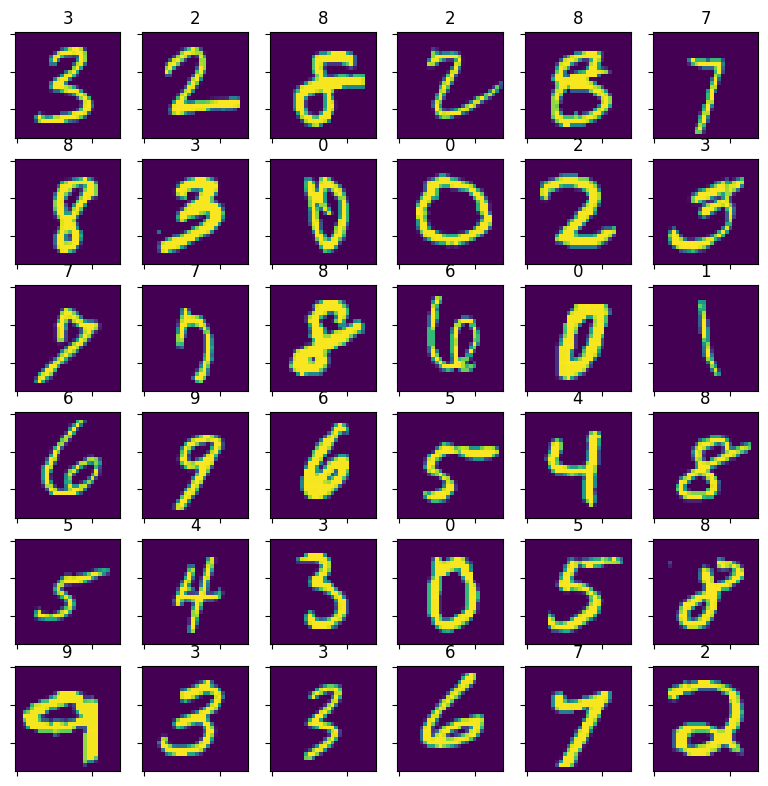

In [6]:
h = 6
w = 6
fig, axs = plt.subplots(h, w, figsize=(1.6*h,1.6*w))
for i in range(h):
  for j in range(w):
    ex = np.random.randint(0, X_train.shape[0])
    predicted_label = np.argmax(y_train[ex])
    axs[i,j].set_title(nombres[predicted_label])
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(X_train[ex].reshape(28, 28))

In [7]:
numimagen = np.sum(y_train, axis=0)

for i in range(10):
    print(f"Cantidad de imágenes del número {i}: {numimagen[i]}")

Cantidad de imágenes del número 0: 5923.0
Cantidad de imágenes del número 1: 6742.0
Cantidad de imágenes del número 2: 5958.0
Cantidad de imágenes del número 3: 6131.0
Cantidad de imágenes del número 4: 5842.0
Cantidad de imágenes del número 5: 5421.0
Cantidad de imágenes del número 6: 5918.0
Cantidad de imágenes del número 7: 6265.0
Cantidad de imágenes del número 8: 5851.0
Cantidad de imágenes del número 9: 5949.0


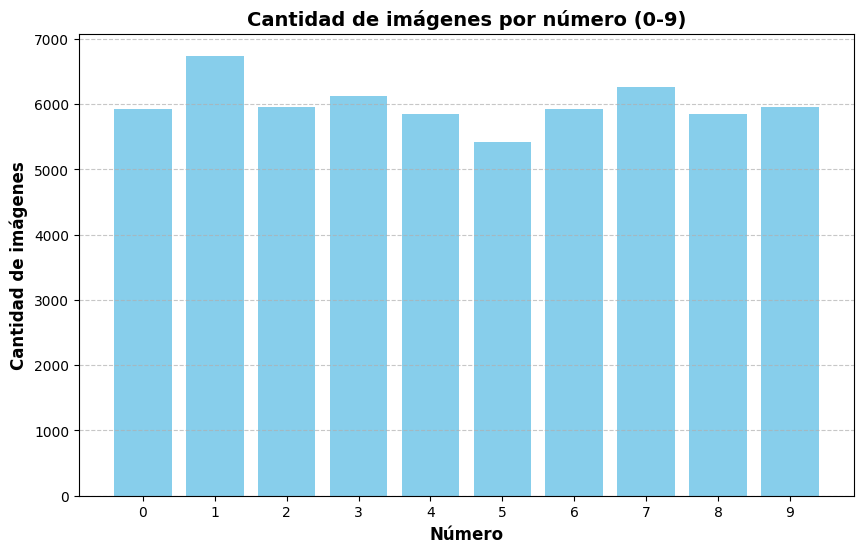

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(numimagen)), numimagen, color='skyblue')
plt.title('Cantidad de imágenes por número (0-9)', fontsize=14, fontweight="bold")
plt.xlabel('Número', fontsize=12, fontweight="bold")
plt.ylabel('Cantidad de imágenes', fontsize=12, fontweight="bold")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(10))
plt.show()

Las imágenes del dataset están relativamente balanceadas entre las 10 clases. La clase con más ejemplos es el número 1 (6742 imágenes) y la que menos tiene es el número 5 (5421 imágenes). Aunque hay pequeñas diferencias, la distribución es lo suficientemente equilibrada como para entrenar modelos sin riesgo significativo de sesgo hacia una clase específica.

# Definición del modelo base

En este primer experimento, se implementará una MLP para realizar la clasificación multiclase utilizando el framework Keras. A continuación se detallan las principales decisiones tomadas durante la construcción del modelo:

In [9]:
M = X_train.shape[0]
N = X_train.shape[1]
C = y_train.shape[1]
print(M,N,C)

60000 784 10


M: Representa la cantidad de imagenes en el conjunto de entrenamiento: 60,000 imágenes de dígitos escritos a mano.

N: Cada imagen tiene 784 píxeles. Esto significa que las imagenes del conjunto de datos son de 28 x 28 píxeles aplanadas en un vector de 784 píxeles.

C: Es la cantidad de clases posibles (dígitos escritos a mano del 0 al 9). Por eso, cada etiqueta en y_train está codificada en one-hot, usando un vector de 10 posiciones con un 1 en la clase correspondiente y 0 en las demás.

In [10]:
np.random.seed(29)
tf.random.set_seed(29)

Se fijaron semillas para asegurar que los resultados sean reproducibles. Es decir, que si se vuelve a ejecutar el mismo modelo, con los mismos datos y esta semilla, se obtendrán los mismos resultados.

##Arquitectura del modelo base

Capa de Entrada: La red comienza con una capa de entrada que tiene un tamaño de 784(n) características. Esta capa está configurada para aceptar los datos de entrada que contienen las características que alimentan el modelo.

Capas Ocultas: En el modelo de base utilizarán tres capas ocultas con 512, 256 y 128 neuronas respectivamente. Esta estructura descendente permite una reducción progresiva de la dimensionalidad, capturando patrones generales en las primeras capas y refinando características más específicas en las capas posteriores.

Capa de Salida: Para la tarea de clasificación multiclase, la capa de salida tiene 10 (C) neuronas, donde C es el número de clases posibles en el problema. La función de activación utilizada en esta capa es Softmax, porque convierte las salidas de la red en probabilidades. Esto es importante para tareas de clasificación, ya que con esta función, las salidas de la red se interpretan como las probabilidades de que una imagen de entrada pertenezca a cada una de las 10 clases posibles, sumando un total de 1. Esto facilita la interpretación de los resultados y asegura que el modelo pueda predecir la clase más probable.

##Función de pérdida

Se utilizará categorical_crossentropy como función de pérdida debido a que el problema es de clasificación multiclase, en el que las etiquetas están representadas en formato one-hot encoding. En este formato, cada clase (dígito del 0 al 9) se codifica como un vector en el que solo una posición está activa, correspondiente a la clase correcta.

La función categorical_crossentropy mide la diferencia entre las probabilidades predichas por el modelo y las verdaderas distribuciones de clases. Su objetivo es minimizar la diferencia entre las predicciones del modelo y las clases reales, penalizando las predicciones incorrectas. Al utilizar esta función de pérdida, se busca que el modelo asigne la mayor probabilidad a la clase correcta, optimizando el aprendizaje en problemas de clasificación multiclase.

En conjunto con la función de activación softmax, la cual también nos entrega probabilidades, y así, se optimiza el rendimiento del modelo. Compara las probabilidades generadas por softmax con las etiquetas reales que están en formato one-hot. Esta función mide la diferencia entre lo que el modelo predice y lo que debería haber predicho, y su objetivo es reducir esa diferencia para mejorar la precisión del modelo.

La razón por la que se eligen estas dos funciones es que ambas están hechas para trabajar con probabilidades. Esto hace que el modelo sea más adecuado para la tarea de clasificación y permita hacer predicciones más precisas.

##Función de activación

Elegimos Relu como función de activación inicial porque es una de las más populares y efectivas en redes neuronales. Su principal ventaja es que es computacionalmente eficiente, ya que solo requiere una operación simple para calcular la activación. Esto facilita el entrenamiento y hace que el modelo sea más rápido. Además, relu ayuda a mitigar el problema del desvanecimiento del gradiente, que puede ocurrir con otras funciones de activación. Esto permite que las redes neuronales más profundas aprendan mejor y más rápido, ya que mantiene un gradiente constante en valores positivos. Aunque ReLU puede producir neuronas muertas cuando se activan valores negativos, su rendimiento en problemas de clasificación hace que sea una excelente opción para comenzar el proceso de entrenamiento.

##Proceso de entrenamiento

En el proceso de entrenamiento, se establecieron los siguientes parámetros:

Épocas: se utilizarán 10 épocas de manera inicial, ya que es una cantidad adecuada para que el modelo aprenda los patrones principales del dataset y se pueda evaluar si está aprendiendo correctamente sin llegar a sobreentrenarse. Esto permite un buen equilibrio entre la calidad del aprendizaje y el tiempo requerido para el entrenamiento.
Batch size: se usará un batch size inicial de 32 porque ofrece un buen rendimiento en cuanto a estabilidad y velocidad durante el proceso, sin exigir demasiados recursos del sistema.

##Optimizador


En este experimento, comenzamos utilizando el optimizador SGD debido a su simplicidad y efectividad en problemas de clasificación, como el dataset utilizado, que es limpio y bien balanceado. Este optimizador será el que utilicemos en todos los experimentos posteriores, manteniendo constantes las demás configuraciones del modelo, como el número de épocas, las funciones de activación y el tamaño del batch. Este enfoque nos permitirá observar cómo afecta el optimizador al rendimiento del modelo. Una vez que hayamos evaluado el desempeño con SGD, procederemos a realizar el cambio al optimizador Adam, pero manteniendo todas las demás configuraciones igual, con el fin de comparar y analizar cómo este optimizador mejora o no el comportamiento de la red en las mismas condiciones. Esto nos permitirá evaluar de manera justa las diferencias de rendimiento entre ambos optimizadores bajo las mismas condiciones experimentales.

El modelo base se entrenará con esta configuración para establecer una línea de referencia en cuanto al rendimiento, la cual se utilizará como comparación cuando se implementen modificaciones en los pasos siguientes.

# Experimento 1: Optimizador SGD

En este primer experimento, comenzaremos con el modelo base descrito previamente, que utiliza la función de activación Relu en sus capas ocultas. Este modelo servirá como nuestra línea de referencia inicial.

In [11]:
h1 = 512
h2 = 256
h3 = 128

red_sgd_relu = keras.Sequential(name="Red_sgd_relu")
red_sgd_relu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_relu.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_relu.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_relu.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_relu.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_relu.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)

start_time = time()
hist_sgd_relu = red_sgd_relu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_sgd_relu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7385 - loss: 0.9951 - precision: 0.9133 - recall: 0.4942 - val_accuracy: 0.9205 - val_loss: 0.2747 - val_precision: 0.9440 - val_recall: 0.9022
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9250 - loss: 0.2591 - precision: 0.9450 - recall: 0.9062 - val_accuracy: 0.9380 - val_loss: 0.2063 - val_precision: 0.9545 - val_recall: 0.9274
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9423 - loss: 0.1975 - precision: 0.9558 - recall: 0.9308 - val_accuracy: 0.9485 - val_loss: 0.1707 - val_precision: 0.9597 - val_recall: 0.9382
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9539 - loss: 0.1605 - precision: 0.9639 - recall: 0.9442 - val_accuracy: 0.9565 - val_loss: 0.1485 - val_precision: 0.9648 - val_recall: 0.9483
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9613 - loss: 0.1344 - precision: 0.9694 - recall: 0.9537 - val_accuracy: 0.9606

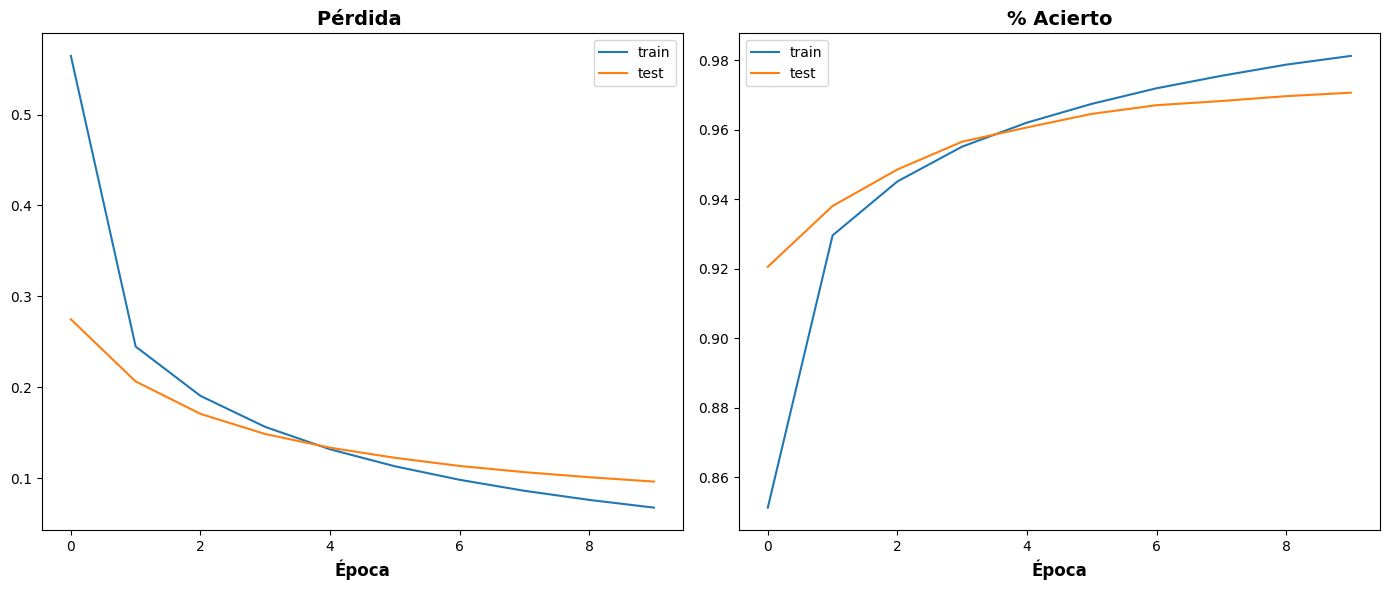

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_relu.history['loss'], label="train")
axs[0].plot(hist_sgd_relu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_relu.history['accuracy'], label="train")
axs[1].plot(hist_sgd_relu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


### Primer cambio: Función de activación de Relu a Elu

En este primer experimento, realizaremos el cambio de la función de activación Relu por Elu en las capas ocultas de la red neuronal. El motivo de este cambio es evaluar si ELU mejora el rendimiento del modelo en comparación con Relu. Mientras que Relu es muy eficiente y ayuda a mitigar el problema del desvanecimiento del gradiente, puede generar "neuronas muertas" al producir valores negativos en su salida. Por otro lado, elu introduce valores negativos en las activaciones, lo que puede hacer que el modelo sea mejor al aprender representaciones más complejas y mejorar la estabilidad del gradiente durante el entrenamiento. A través de este cambio, buscamos analizar si ELU permite una mejor convergencia y un mejor ajuste en el modelo, lo cual podría optimizar su rendimiento en tareas de clasificación multiclase. A continuación, presentamos el código que implementa esta modificación en la función de activación.

In [13]:
red_sgd_elu = keras.Sequential(name="red_sgd_elu")
red_sgd_elu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_elu.add(keras.layers.Dense(h1, activation='elu',name='primera_capa'))
red_sgd_elu.add(keras.layers.Dense(h2, activation='elu',name='segunda_capa'))
red_sgd_elu.add(keras.layers.Dense(h3, activation='elu',name='tercera_capa'))
red_sgd_elu.add(keras.layers.Dense(C, activation='softmax', name='capa_salida'))

red_sgd_elu.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_elu = red_sgd_elu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_elu.save("red_sgd_elu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8111 - loss: 0.6899 - precision: 0.9362 - recall: 0.6584 - val_accuracy: 0.9141 - val_loss: 0.2871 - val_precision: 0.9356 - val_recall: 0.8960
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9189 - loss: 0.2817 - precision: 0.9398 - recall: 0.9002 - val_accuracy: 0.9280 - val_loss: 0.2441 - val_precision: 0.9440 - val_recall: 0.9161
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9312 - loss: 0.2379 - precision: 0.9478 - recall: 0.9172 - val_accuracy: 0.9377 - val_loss: 0.2123 - val_precision: 0.9509 - val_recall: 0.9266
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9407 - loss: 0.2043 - precision: 0.9548 - recall: 0.9305 - val_accuracy: 0.9451 - val_loss: 0.1864 - val_precision: 0.9571 - val_recall: 0.9354
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9490 - loss: 0.1775 - precision: 0.9604 - recall: 0.9393 - val_accuracy: 0.9508

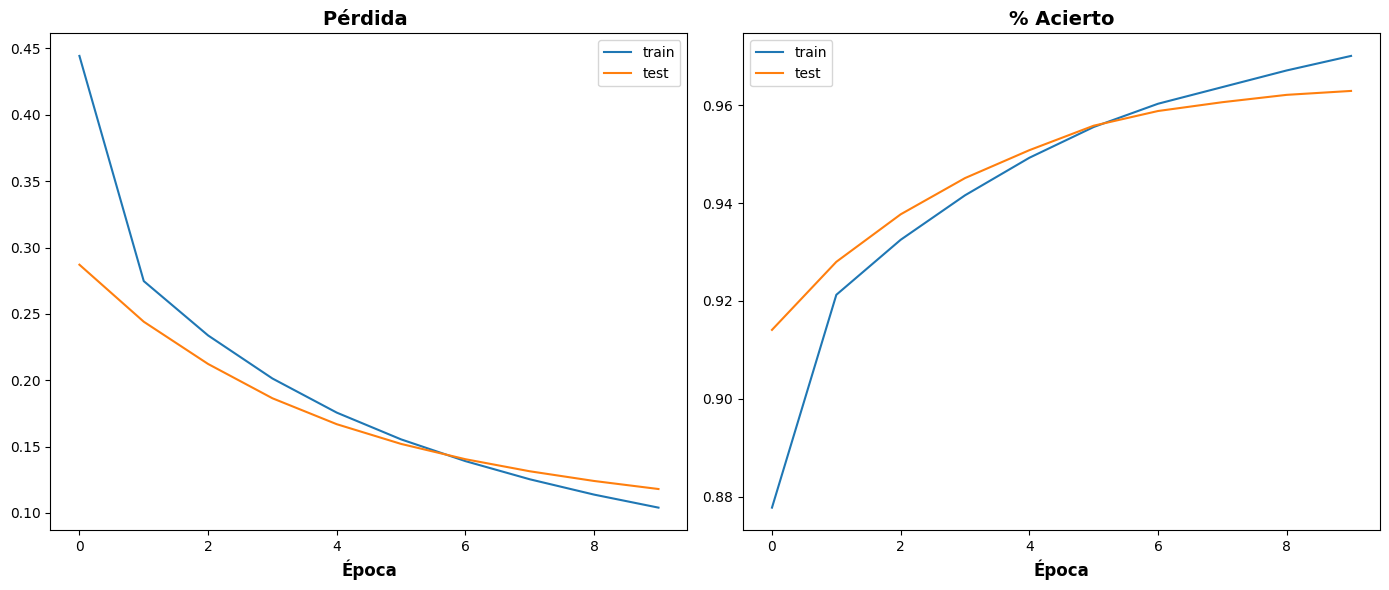

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_elu.history['loss'], label="train")
axs[0].plot(hist_sgd_elu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_elu.history['accuracy'], label="train")
axs[1].plot(hist_sgd_elu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


In [15]:
relu_vs_elu = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'hist_relu': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'hist_elu': [hist_sgd_elu.history[k][-1] for k in hist_sgd_elu.history]
}


df = pd.DataFrame(relu_vs_elu)

display(df)

,Métrica,hist_relu,hist_elu
0,accuracy,0.981183,0.970050
1,loss,0.067477,0.104006
2,precision,0.985021,0.975755
3,recall,0.977667,0.964550
4,val_accuracy,0.970600,0.962900
5,val_loss,0.096154,0.118032
6,val_precision,0.974610,0.969388
7,val_recall,0.967300,0.959500


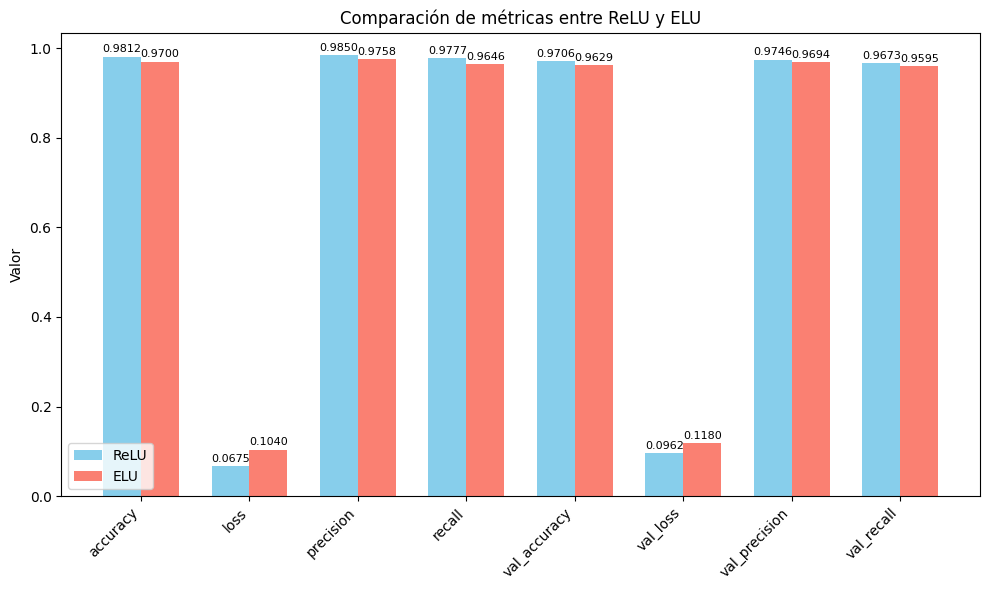

In [51]:
# Extraer datos
metricas = df['Métrica']
valores_relu = df['hist_relu']
valores_elu = df['hist_elu']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.35  # ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, valores_relu, width, label='ReLU', color='skyblue')
bars2 = ax.bar(x + width/2, valores_elu, width, label='ELU', color='salmon')

# Etiquetas y títulos
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre ReLU y ELU')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

En accuracy Relu alcanza un 98.12%, superando a ELU que obtiene un 97.00%. Esto indica que Relu permite al modelo ajustarse mejor a los datos de entrenamiento. En pérdida Relu logra un porcentaje menor (0.0675) en comparación a ELU (0.1040), confirmando un mejor aprendizaje del modelo.

En terminos de validación el modelo con Relu mantiene una mejor generalización  (97.06%) frente a ELU con 96.29%. Y en validación de perdida ReLu nuevamente se presenta como la mejor opción con in val_loss del 0.0962, lo que indica menor error en los datos no vistos.

Sin embargo, en Relu existe el riesgo de "neuronas muertas", lo que puede afectar el aprendizaje en redes más profundas o con pesos mal inicializados. Y ELU tiene la capacidad de producir salidas negativas ayuda a evitar el problema de las neuronas muertas, lo cual puede ser beneficioso en ciertos contextos o arquitectura.

En resumen, Relu se comportó mejor en este caso específico, pero ELU podría ofrecer ventajas en modelos más complejos o con problemas de desactivación de neuronas. Ya que nuestro set de datos es simple, se elegirá la funcion Relu como función activadora para los siguientes cambios.

## Segundo cambio: batch size

### Batch size de 64

En este experimento se modifica el tamaño del batch de 32 a 64 con el objetivo de evaluar cómo afecta al rendimiento del modelo. Un batch más grande puede hacer el entrenamiento más eficiente y estable al promediar mejor los gradientes, aunque también puede reducir la capacidad de generalización. Con este cambio, buscamos analizar si se logran mejoras sin comprometer la precisión del modelo.

In [16]:
red_sgd_batch64 = keras.Sequential(name="red_sgd_bs64")
red_sgd_batch64.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_batch64.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_batch64.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_batch64.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_batch64.add(keras.layers.Dense(C, activation='softmax', name='capa_salida'))

red_sgd_batch64.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_batch64 = red_sgd_batch64.fit(X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_sgd_batch64.save("red_sgd_batch64.keras")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6564 - loss: 1.2981 - precision: 0.8633 - recall: 0.3231 - val_accuracy: 0.9049 - val_loss: 0.3392 - val_precision: 0.9382 - val_recall: 0.8714
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9075 - loss: 0.3248 - precision: 0.9382 - recall: 0.8778 - val_accuracy: 0.9245 - val_loss: 0.2620 - val_precision: 0.9443 - val_recall: 0.9051
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9260 - loss: 0.2575 - precision: 0.9466 - recall: 0.9074 - val_accuracy: 0.9366 - val_loss: 0.2236 - val_precision: 0.9519 - val_recall: 0.9201
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9371 - loss: 0.2191 - precision: 0.9534 - recall: 0.9223 - val_accuracy: 0.9435 - val_loss: 0.1973 - val_precision: 0.9567 - val_recall: 0.9315
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9452 - loss: 0.1910 - precision: 0.9589 - recall: 0.9335 - val_accuracy: 0.9488 - val_loss: 

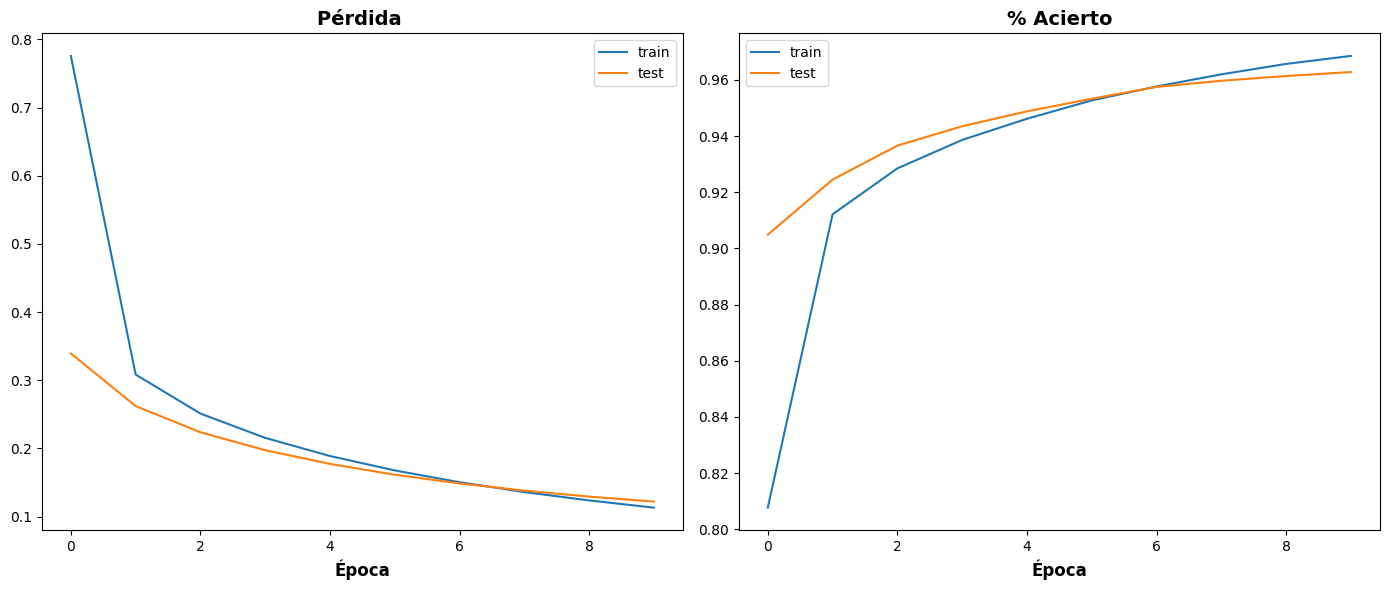

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_batch64.history['loss'], label="train")
axs[0].plot(hist_sgd_batch64.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_batch64.history['accuracy'], label="train")
axs[1].plot(hist_sgd_batch64.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


### Batch size de 256

En este experimento se aumenta el tamaño del batch a 256 para observar su impacto en el rendimiento del modelo. Al usar batches más grandes, se reduce la variabilidad del gradiente, lo que puede acelerar el entrenamiento, pero también corre el riesgo de perder capacidad de generalización. Este cambio nos permite analizar ese equilibrio.

In [18]:
red_sgd_batch256 = keras.Sequential(name="red_sgd_bs264")
red_sgd_batch256.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_batch256.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_batch256.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_batch256.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_batch256.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_batch256.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_batch256 = red_sgd_batch256.fit(X_train, y_train,
        epochs=10,
        batch_size=256,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_sgd_batch256.save("red_sgd_batch256.keras")

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3788 - loss: 2.0284 - precision: 0.6716 - recall: 0.0161 - val_accuracy: 0.8061 - val_loss: 0.9740 - val_precision: 0.9820 - val_recall: 0.3710
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8215 - loss: 0.8125 - precision: 0.9697 - recall: 0.5281 - val_accuracy: 0.8706 - val_loss: 0.4986 - val_precision: 0.9457 - val_recall: 0.7827
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8724 - loss: 0.4812 - precision: 0.9436 - recall: 0.7883 - val_accuracy: 0.8931 - val_loss: 0.3858 - val_precision: 0.9408 - val_recall: 0.8450
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8951 - loss: 0.3855 - precision: 0.9395 - recall: 0.8446 - val_accuracy: 0.9074 - val_loss: 0.3343 - val_precision: 0.9415 - val_recall: 0.8707
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9051 - loss: 0.3380 - precision: 0.9402 - recall: 0.8691 - val_accuracy: 0.9143 - val_los

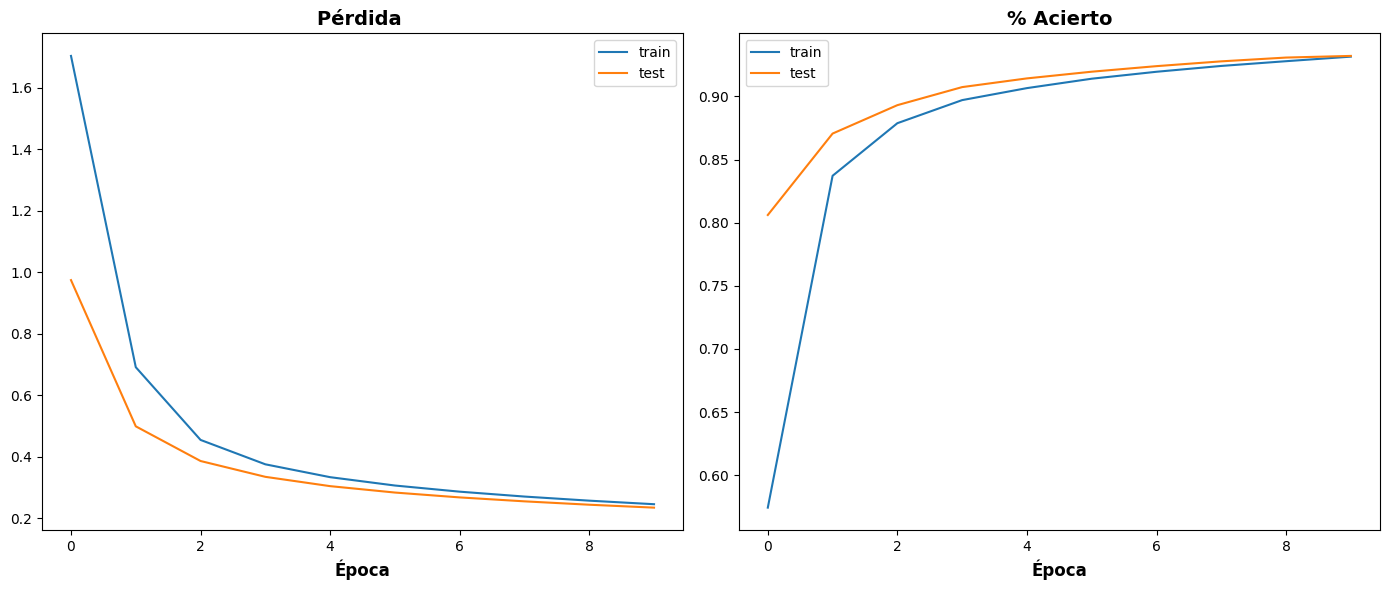

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_batch256.history['loss'], label="train")
axs[0].plot(hist_sgd_batch256.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_batch256.history['accuracy'], label="train")
axs[1].plot(hist_sgd_batch256.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


In [20]:
Batch_size_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'batch size = 32': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'batch size = 64': [hist_sgd_batch64.history[k][-1] for k in hist_sgd_batch64.history],
    'batch size = 256': [hist_sgd_batch256.history[k][-1] for k in hist_sgd_batch256.history],
}

df_batch = pd.DataFrame(Batch_size_vs)

display(df_batch)

,Métrica,batch size = 32,batch size = 64,batch size = 256
0,accuracy,0.981183,0.968550,0.931533
1,loss,0.067477,0.113012,0.245326
2,precision,0.985021,0.975441,0.951028
3,recall,0.977667,0.961833,0.912417
4,val_accuracy,0.970600,0.962800,0.932100
5,val_loss,0.096154,0.121905,0.234185
6,val_precision,0.974610,0.968100,0.952401
7,val_recall,0.967300,0.959000,0.918400


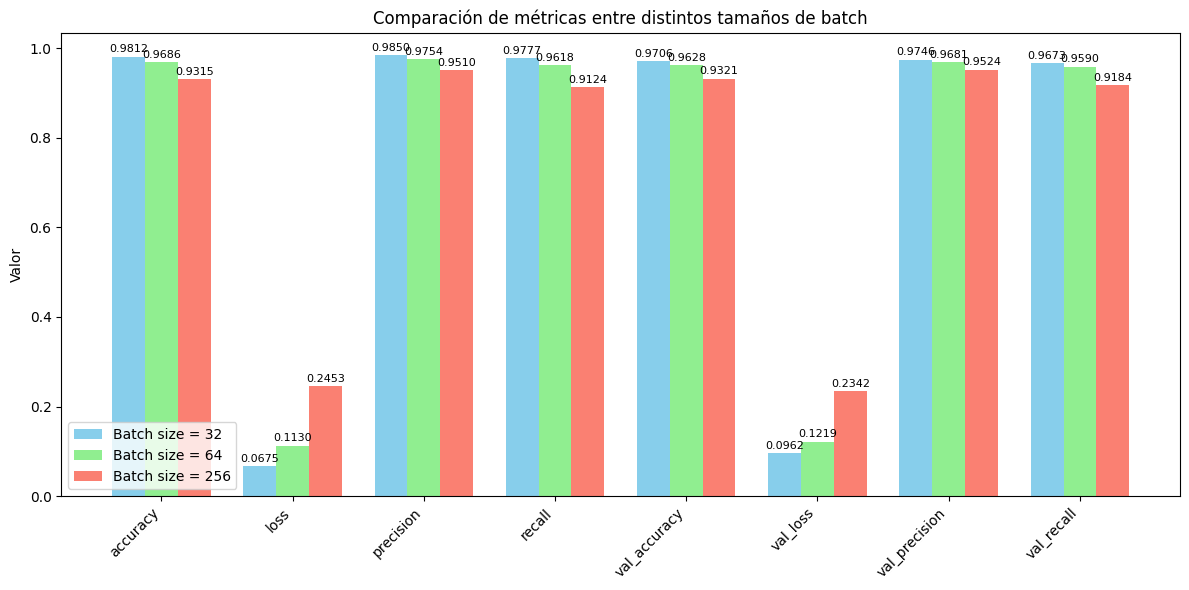

In [52]:
# Extraer datos
metricas = df_batch['Métrica']
valores_32 = df_batch['batch size = 32']
valores_64 = df_batch['batch size = 64']
valores_256 = df_batch['batch size = 256']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.25  # ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, valores_32, width, label='Batch size = 32', color='skyblue')
bars2 = ax.bar(x, valores_64, width, label='Batch size = 64', color='lightgreen')
bars3 = ax.bar(x + width, valores_256, width, label='Batch size = 256', color='salmon')

# Etiquetas y títulos
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre distintos tamaños de batch')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2 + bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

El tamaño de batch de 32 produjo los mejores resultados en todas las métricas evaluadas, tanto en entrenamiento como en validación. Esto sugiere que, para este problema/contexto, los pequeños grupos permiten al modelo capturar mejor los patrones de los datos y generalizar de forma más efectiva.

A medida que el tamaño del batch aumenta, se observa una pérdida de rendimiento. Si bien batches más grandes pueden acelerar el entrenamiento, en este caso se comprometen métricas mejores y menor overfitting.

Por mejores resultados en las métricas nos quedaremos con un batch size de 32 para los siguientes experimentos.

## Tercer Cambio: épocas

En este experimento se aumenta el número de épocas a 30 con el objetivo de permitir que el modelo tenga más oportunidades de aprender a partir de los datos. Al extender el entrenamiento, se busca mejorar la precisión y reducir el error, evaluando al mismo tiempo si existe riesgo de sobreajuste.

In [21]:
red_sgd_epoca = keras.Sequential(name="red_sgd_epoca")
red_sgd_epoca.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_epoca.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_epoca.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_epoca.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_epoca.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_epoca.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_sgd_epoca = red_sgd_epoca.fit(X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_sgd_epoca.save("red_sgd_epoca.keras")

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7408 - loss: 0.9628 - precision: 0.9082 - recall: 0.5110 - val_accuracy: 0.9215 - val_loss: 0.2692 - val_precision: 0.9427 - val_recall: 0.9038
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9256 - loss: 0.2547 - precision: 0.9458 - recall: 0.9085 - val_accuracy: 0.9418 - val_loss: 0.2021 - val_precision: 0.9546 - val_recall: 0.9289
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9449 - loss: 0.1912 - precision: 0.9589 - recall: 0.9321 - val_accuracy: 0.9512 - val_loss: 0.1651 - val_precision: 0.9623 - val_recall: 0.9414
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9563 - loss: 0.1527 - precision: 0.9672 - recall: 0.9469 - val_accuracy: 0.9579 - val_loss: 0.1414 - val_precision: 0.9662 - val_recall: 0.9506
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9642 - loss: 0.1265 - precision: 0.9726 - recall: 0.9568 - val_accuracy: 0.963

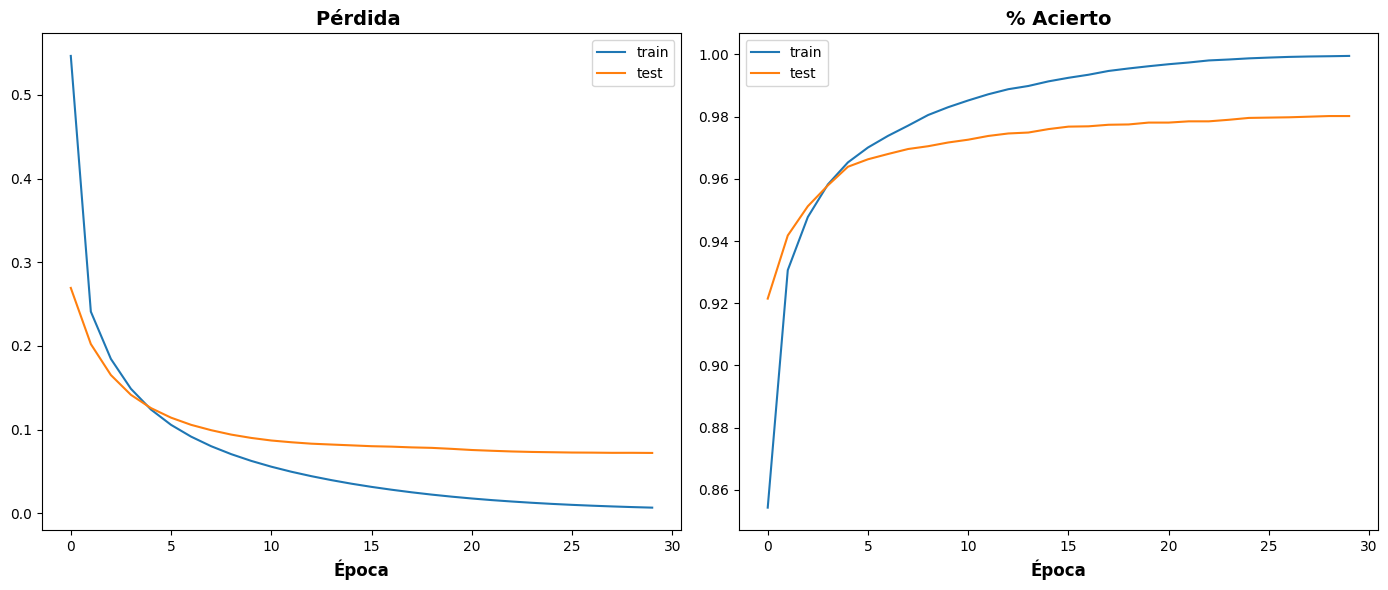

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_epoca.history['loss'], label="train")
axs[0].plot(hist_sgd_epoca.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_epoca.history['accuracy'], label="train")
axs[1].plot(hist_sgd_epoca.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

In [23]:
Epoca_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'Epoca = 10': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'Epoca = 30': [hist_sgd_epoca.history[k][-1] for k in hist_sgd_epoca.history],
    #'Epoca = 50': [.history[k][-1] for k in .history],
}

df_epoca = pd.DataFrame(Epoca_vs)

display(df_epoca)

,Métrica,Epoca = 10,Epoca = 30
0,accuracy,0.981183,0.999533
1,loss,0.067477,0.006626
2,precision,0.985021,0.999633
3,recall,0.977667,0.999433
4,val_accuracy,0.970600,0.980200
5,val_loss,0.096154,0.071994
6,val_precision,0.974610,0.981650
7,val_recall,0.967300,0.979000


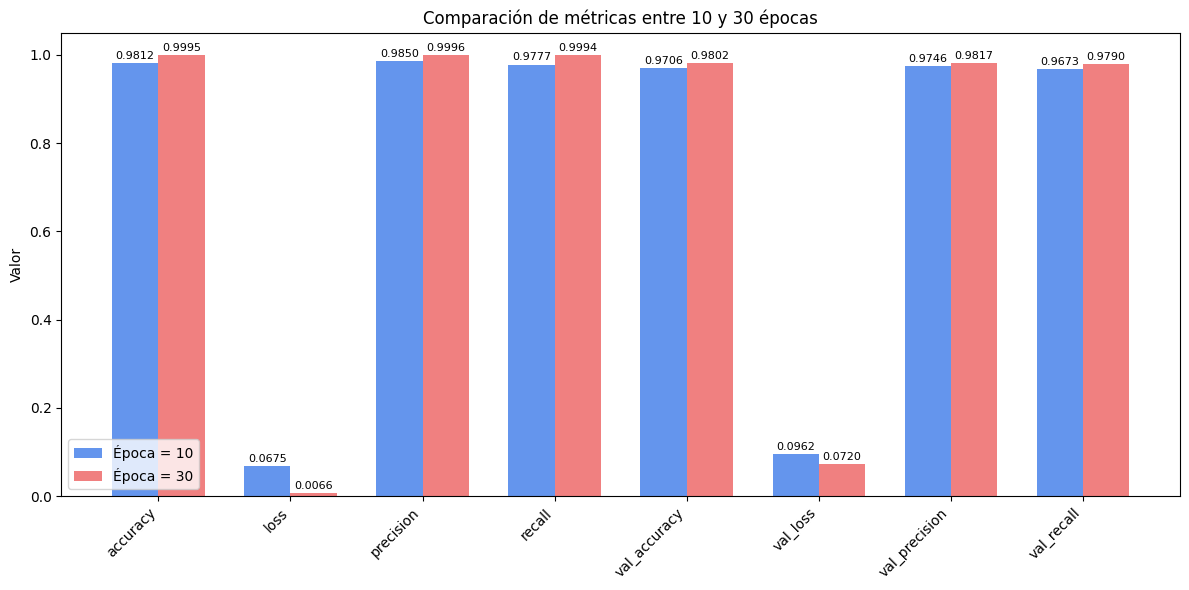

In [53]:
# Extraer datos
metricas = df_epoca['Métrica']
valores_10 = df_epoca['Epoca = 10']
valores_30 = df_epoca['Epoca = 30']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.35  # ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, valores_10, width, label='Época = 10', color='cornflowerblue')
bars2 = ax.bar(x + width/2, valores_30, width, label='Época = 30', color='lightcoral')

# Etiquetas y títulos
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre 10 y 30 épocas')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

El aumento del número de épocas de entrenamiento de 10 a 30 tuvo un impacto positivo en el rendimiento del modelo, tanto en los datos de entrenamiento como en los de validación. No se observan signos claros de sobreajuste en esta comparación: aunque el modelo mejora mucho en entrenamiento, también lo hace en validación.

Por tanto, entrenar por 30 épocas podría ser una opción en este caso, ya que permite al modelo aprender mejor sin comprometer su capacidad de generalización.

Pero si el número de épocas siguiera aumentando más allá de 30, podría comenzar a aparecer sobreajuste.

Aunque entrenar el modelo por 30 épocas brinda una mejora en las métricas, esta diferencia no es tan significativa en comparación a los recursos computacionales, por esta razón los siguientes experimentos se mantendran de 10 épocas

## Cuarto cambio: capas ocultas

En este experimento se modifica la arquitectura del modelo añadiendo una capa oculta adicional. El objetivo es analizar cómo el incremento en la profundidad de la red afecta el desempeño, ya que una mayor cantidad de capas puede permitir la captura de patrones más complejos, aunque también puede aumentar el riesgo de sobreajuste.

In [24]:
h4=64

red_sgd_capa4 = keras.Sequential(name="Red_sgd_4capas")
red_sgd_capa4.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_capa4.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_sgd_capa4.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_sgd_capa4.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_sgd_capa4.add(keras.layers.Dense(h4, activation='relu',name='cuarta_capa'))
red_sgd_capa4.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_sgd_capa4.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_sgd_capa4 = red_sgd_capa4.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_capa4.save("red_sgd_capa4.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7129 - loss: 1.0205 - precision: 0.8937 - recall: 0.4905 - val_accuracy: 0.9259 - val_loss: 0.2522 - val_precision: 0.9462 - val_recall: 0.9096
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9290 - loss: 0.2407 - precision: 0.9481 - recall: 0.9132 - val_accuracy: 0.9480 - val_loss: 0.1760 - val_precision: 0.9601 - val_recall: 0.9394
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9500 - loss: 0.1700 - precision: 0.9615 - recall: 0.9402 - val_accuracy: 0.9589 - val_loss: 0.1412 - val_precision: 0.9662 - val_recall: 0.9514
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9614 - loss: 0.1309 - precision: 0.9697 - recall: 0.9546 - val_accuracy: 0.9629 - val_loss: 0.1224 - val_precision: 0.9695 - val_recall: 0.9575
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9698 - loss: 0.1054 - precision: 0.9766 - recall: 0.9644 - val_accuracy: 0.9667

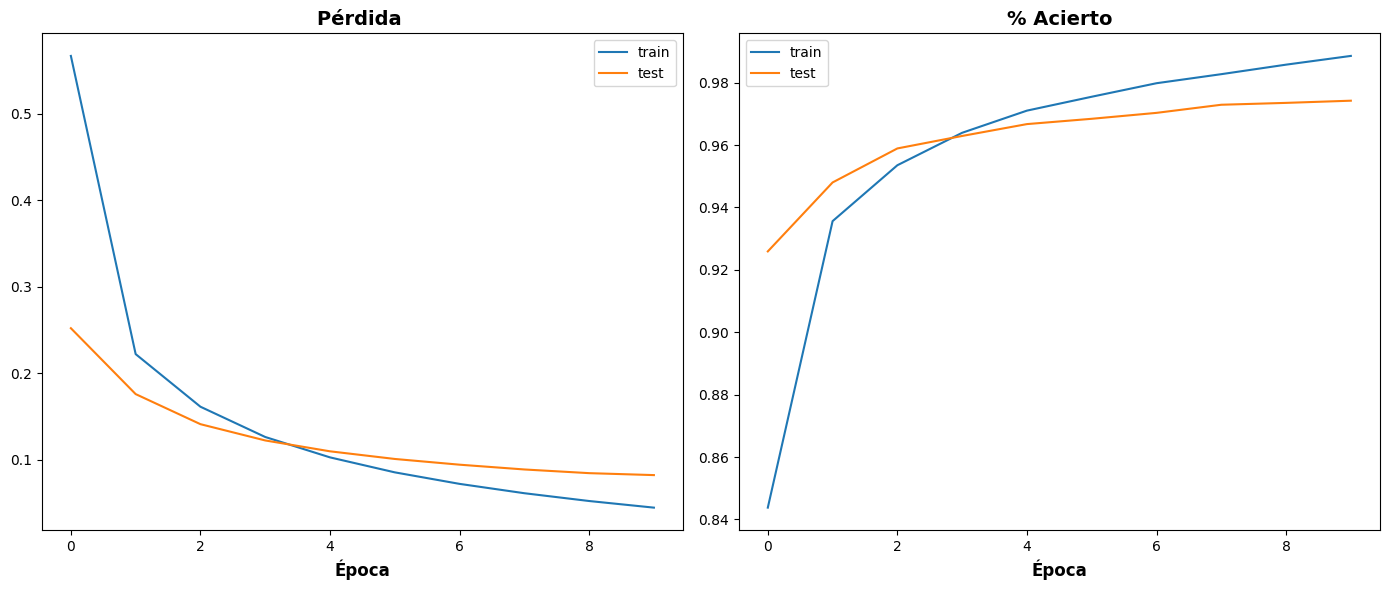

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_capa4.history['loss'], label="train")
axs[0].plot(hist_sgd_capa4.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_capa4.history['accuracy'], label="train")
axs[1].plot(hist_sgd_capa4.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

In [26]:
Capas_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'Capas = 3': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'Capas = 4': [hist_sgd_capa4.history[k][-1] for k in hist_sgd_capa4.history]
}

df_capas = pd.DataFrame(Capas_vs)

display(df_capas)

,Métrica,Capas = 3,Capas = 4
0,accuracy,0.981183,0.988550
1,loss,0.067477,0.044657
2,precision,0.985021,0.990511
3,recall,0.977667,0.986483
4,val_accuracy,0.970600,0.974200
5,val_loss,0.096154,0.082289
6,val_precision,0.974610,0.977177
7,val_recall,0.967300,0.971900


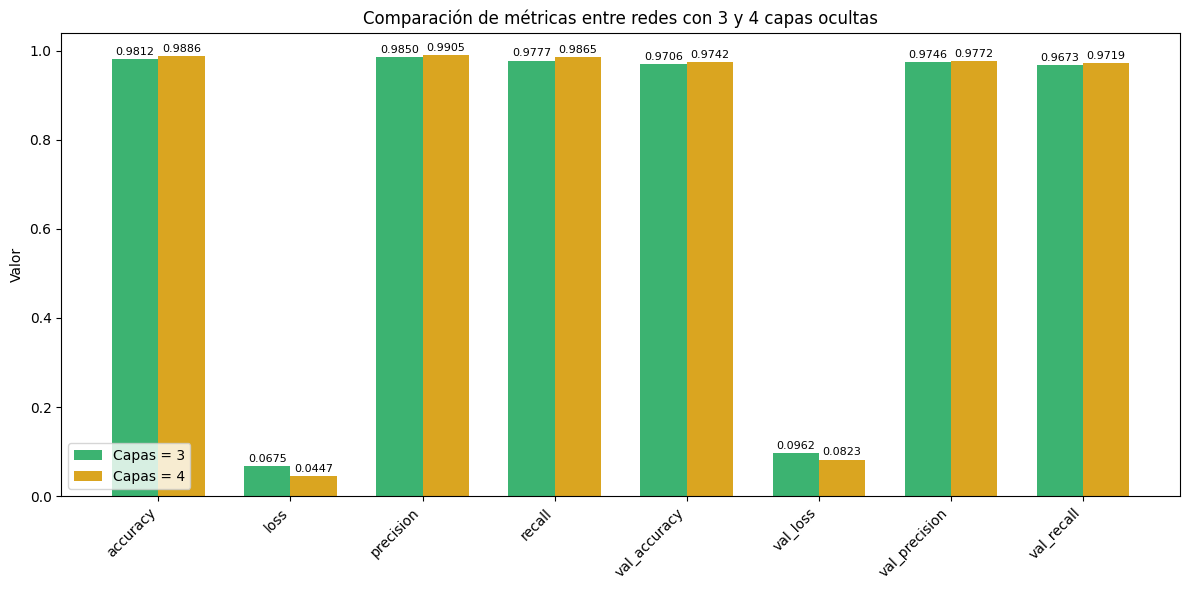

In [54]:
# Extraer datos
metricas = df_capas['Métrica']
valores_3capas = df_capas['Capas = 3']
valores_4capas = df_capas['Capas = 4']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.35  # ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, valores_3capas, width, label='Capas = 3', color='mediumseagreen')
bars2 = ax.bar(x + width/2, valores_4capas, width, label='Capas = 4', color='goldenrod')

# Etiquetas y títulos
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre redes con 3 y 4 capas ocultas')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

Agregar una cuarta capa oculta proporciona una ligera mejora en las métricas, tanto en entrenamiento como en validación. Sin embargo, la mejora de métricas es tan baja que agregar otra y aumentar los recursos computacionales no genera mucho beneficio.

El modelo con 3 capas ya es suficientemente expresivo para resolver bien el problema. La cuarta capa no causa sobreajuste, pero tampoco mejora considerablemente el rendimiento.

Ya que buscamos simplicidad y eficiencia pero con métricas buenas, se utilizará el modelo con 3 capas para los demás experimentos ya que ofrece resultados muy similares con menor tiempo de entrenamiento.

## Quinto cambio: Agregación de regularización (drop-out)

En este experimento se incorpora regularización mediante la técnica de dropout. Esta técnica consiste en "apagar" aleatoriamente un porcentaje de neuronas durante el entrenamiento, lo que ayuda a prevenir el sobreajuste y mejora la capacidad de generalización del modelo. El objetivo es observar cómo impacta esta estrategia en el rendimiento de la red.

In [27]:
red_sgd_dropout = keras.Sequential(name="red_sgd_dropout")
red_sgd_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_dropout.add(keras.layers.Dense(h1, activation='relu'))
red_sgd_dropout.add(keras.layers.Dropout(0.3))
red_sgd_dropout.add(keras.layers.Dense(h2, activation='relu'))
red_sgd_dropout.add(keras.layers.Dense(h3, activation='relu'))
red_sgd_dropout.add(keras.layers.Dense(C, activation='softmax'))

red_sgd_dropout.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_sgd_dropout = red_sgd_dropout.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_sgd_dropout.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6931 - loss: 1.0684 - precision: 0.8913 - recall: 0.4629 - val_accuracy: 0.9202 - val_loss: 0.2727 - val_precision: 0.9416 - val_recall: 0.9031
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9110 - loss: 0.3007 - precision: 0.9352 - recall: 0.8888 - val_accuracy: 0.9398 - val_loss: 0.2022 - val_precision: 0.9552 - val_recall: 0.9295
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9344 - loss: 0.2277 - precision: 0.9504 - recall: 0.9190 - val_accuracy: 0.9499 - val_loss: 0.1628 - val_precision: 0.9619 - val_recall: 0.9429
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9461 - loss: 0.1829 - precision: 0.9587 - recall: 0.9344 - val_accuracy: 0.9577 - val_loss: 0.1371 - val_precision: 0.9671 - val_recall: 0.9521
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9548 - loss: 0.1531 - precision: 0.9656 - recall: 0.9459 - val_accuracy: 0.9633

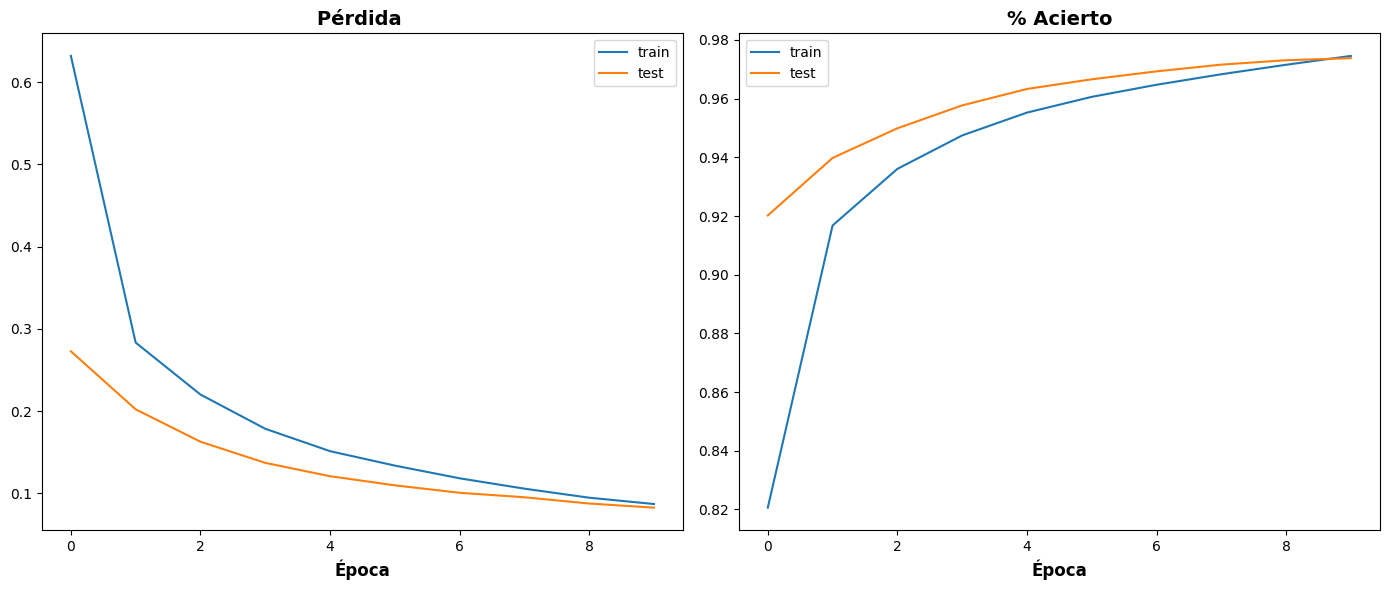

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_sgd_dropout.history['loss'], label="train")
axs[0].plot(hist_sgd_dropout.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_sgd_dropout.history['accuracy'], label="train")
axs[1].plot(hist_sgd_dropout.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


In [29]:
Dropout_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'Sin DropOut': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'Con DropOut': [hist_sgd_dropout.history[k][-1] for k in hist_sgd_dropout.history]
}

df_dropout = pd.DataFrame(Dropout_vs)

display(df_dropout)

,Métrica,Sin DropOut,Con DropOut
0,accuracy,0.981183,0.974567
1,loss,0.067477,0.087054
2,precision,0.985021,0.979274
3,recall,0.977667,0.970183
4,val_accuracy,0.970600,0.973800
5,val_loss,0.096154,0.082658
6,val_precision,0.974610,0.977243
7,val_recall,0.967300,0.970500


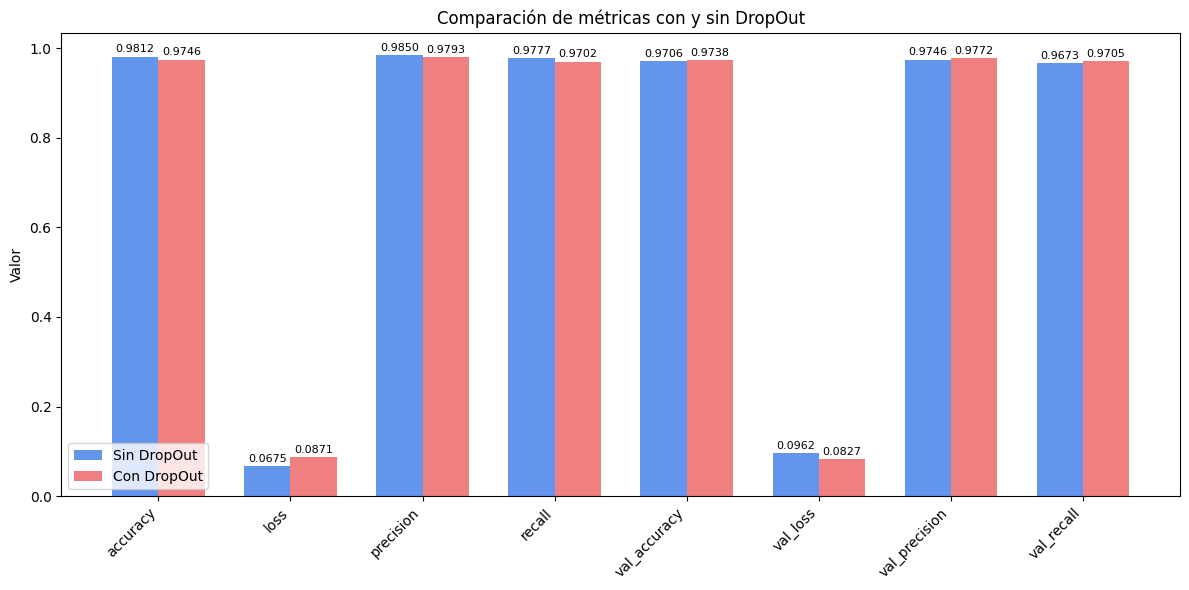

In [55]:
# Extraer los datos de las métricas y sus valores
Dropout_vs = {
    'Métrica': list(hist_sgd_relu.history.keys()),
    'Sin DropOut': [hist_sgd_relu.history[k][-1] for k in hist_sgd_relu.history],
    'Con DropOut': [hist_sgd_dropout.history[k][-1] for k in hist_sgd_dropout.history]
}

df_dropout = pd.DataFrame(Dropout_vs)

# Extraer datos
metricas = df_dropout['Métrica']
valores_sin_dropout = df_dropout['Sin DropOut']
valores_con_dropout = df_dropout['Con DropOut']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.35  # ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, valores_sin_dropout, width, label='Sin DropOut', color='cornflowerblue')
bars2 = ax.bar(x + width/2, valores_con_dropout, width, label='Con DropOut', color='lightcoral')

# Etiquetas y títulos
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas con y sin DropOut')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

Las métricas del modelo con dropout resultaron ser inferiores en comparación con el modelo sin esta técnica. Este comportamiento es esperable, ya que el dropout introduce variaciones intencionales durante el entrenamiento, forzando al modelo a no depender de neuronas específicas. Aunque esto puede dificultar el aprendizaje inicial, su objetivo es mejorar la capacidad de generalización y prevenir el sobreajuste en etapas más avanzadas del entrenamiento.

El uso de Dropout reduce el rendimiento del modelo durante el entrenamiento, pero logra mejorar levemente su capacidad de generalización, como se ve en la mejora de las métricas de validación. Esto cumple con su propósito, evitar que el modelo se sobreentrene. Aunque no haya tanta difererencia en las métricas podemos decir que la técnica de dropout ayuda a prevenir el sobre ajuste y es una muy buena opcion cuando un modelo empieza a mostrar overfitting, aunque en nuestro caso no es tan necesario.

## Mejor modelo experimento 1

Para la selección del mejor modelo utilizaremos la métrica de validación en predicción (val_accuracy), ya que esta mide qué tan bien el modelo generaliza frente a datos no vistos. En términos simples, indica el porcentaje de imágenes que fueron clasificadas correctamente durante la validación. Dado que nuestro objetivo es maximizar la cantidad de predicciones correctas sobre datos reales, esta métrica resulta la más adecuada para guiar la elección del modelo final.

In [30]:
# Lista de modelos y sus historiales
modelos = [red_sgd_relu, red_sgd_elu, red_sgd_batch64, red_sgd_batch256, red_sgd_epoca, red_sgd_capa4, red_sgd_dropout]
historiales = [hist_sgd_relu, hist_sgd_elu, hist_sgd_batch64, hist_sgd_batch256, hist_sgd_epoca, hist_sgd_capa4, hist_sgd_dropout]

# Obtener la lista de val_accuracy final de cada modelo
val_accuracies = [h.history['val_accuracy'][-1] for h in historiales]

# Encontrar el índice del modelo con mayor val_accuracy
indice_mejor = val_accuracies.index(max(val_accuracies))

# Obtener el mejor modelo y su historial
mejor_modelo = modelos[indice_mejor]
nombre_mejor_modelo = mejor_modelo.name
hist_mejor = historiales[indice_mejor]

# Extraer métricas
acc = hist_mejor.history['accuracy'][-1]
val_acc = hist_mejor.history['val_accuracy'][-1]
loss = hist_mejor.history['loss'][-1]
val_loss = hist_mejor.history['val_loss'][-1]
recall = hist_mejor.history['recall'][-1]
precision = hist_mejor.history['precision'][-1]
f1_score = 2 * (precision * recall) / (precision + recall)

# Mostrar resultados
print(f"Mejor modelo según mayor Val Accuracy:")
print(f"Modelo:         {nombre_mejor_modelo}")
print(f"Accuracy:       {acc:.4f}")
print(f"Val Accuracy:   {val_acc:.4f}")
print(f"Loss:           {loss:.4f}")
print(f"Val Loss:       {val_loss:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"F1 Score:       {f1_score:.4f}")

# Guardar el mejor modelo
mejor_modelo.save("modelo_mejor_sgd.keras")

Mejor modelo según mayor Val Accuracy:
Modelo:         red_sgd_epoca
Accuracy:       0.9995
Val Accuracy:   0.9802
Loss:           0.0066
Val Loss:       0.0720
Recall:         0.9994
Precision:      0.9996
F1 Score:       0.9995


Tras realizar múltiples experimentos variando funciones de activación, batch size, optimizadores, regularización y número de épocas, se determinó que el mejor modelo en términos de rendimiento general es el red_sgd_epoca.

Este modelo se destacó por obtener la mayor precisión en validación (val_accuracy) de todos los experimentos realizados, alcanzando un 97.87%, lo cual indica una excelente capacidad de generalización. Además, presenta métricas excelentes.

Aprende muy bien los datos de entrenamiento (alto accuracy y baja pérdida).

Generaliza correctamente con un diferencia de accuracy pequeño (2.1%), lo cual descarta un sobreajuste significativo.

Tiene un equilibrio excelente entre precisión y recall, lo que lo hace confiable para tareas críticas donde los falsos positivos y negativos deben minimizarse.

Concluciones del optimizador:

A pesar de ser un optimizador más simple comparado con Adam, SGD (Stochastic Gradient Descent) demostró un desempeño eficaz cuando se combina con un buen número de épocas de entrenamiento.

Finalmente, este modelo ofrece un buen balance entre precisión, generalización y estabilidad, lo que lo convierte en una opción segura y eficiente para ser desplegada en un entorno productivo.

# Experimento 2: Optimizador Adam

Se aplicaran los mismos 5 cambios que el experimento anterior pero el optimizador a ocupar en este sera cambiado por adam

## Primer cambio: Función de activación de Relu a Elu

In [31]:
red_adam_relu = keras.Sequential(name="red_adam_relu")
red_adam_relu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_relu.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_relu.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_relu.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_relu.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_relu.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_relu = red_adam_relu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_relu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8987 - loss: 0.3329 - precision: 0.9387 - recall: 0.8620 - val_accuracy: 0.9656 - val_loss: 0.1112 - val_precision: 0.9719 - val_recall: 0.9597
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9725 - loss: 0.0927 - precision: 0.9770 - recall: 0.9683 - val_accuracy: 0.9648 - val_loss: 0.1135 - val_precision: 0.9710 - val_recall: 0.9603
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9799 - loss: 0.0628 - precision: 0.9829 - recall: 0.9776 - val_accuracy: 0.9699 - val_loss: 0.1121 - val_precision: 0.9725 - val_recall: 0.9672
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9846 - loss: 0.0491 - precision: 0.9867 - recall: 0.9831 - val_accuracy: 0.9728 - val_loss: 0.1040 - val_precision: 0.9754 - val_recall: 0.9715
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9880 - loss: 0.0378 - precision: 0.9889 - recall: 0.9867 - val_accuracy: 0

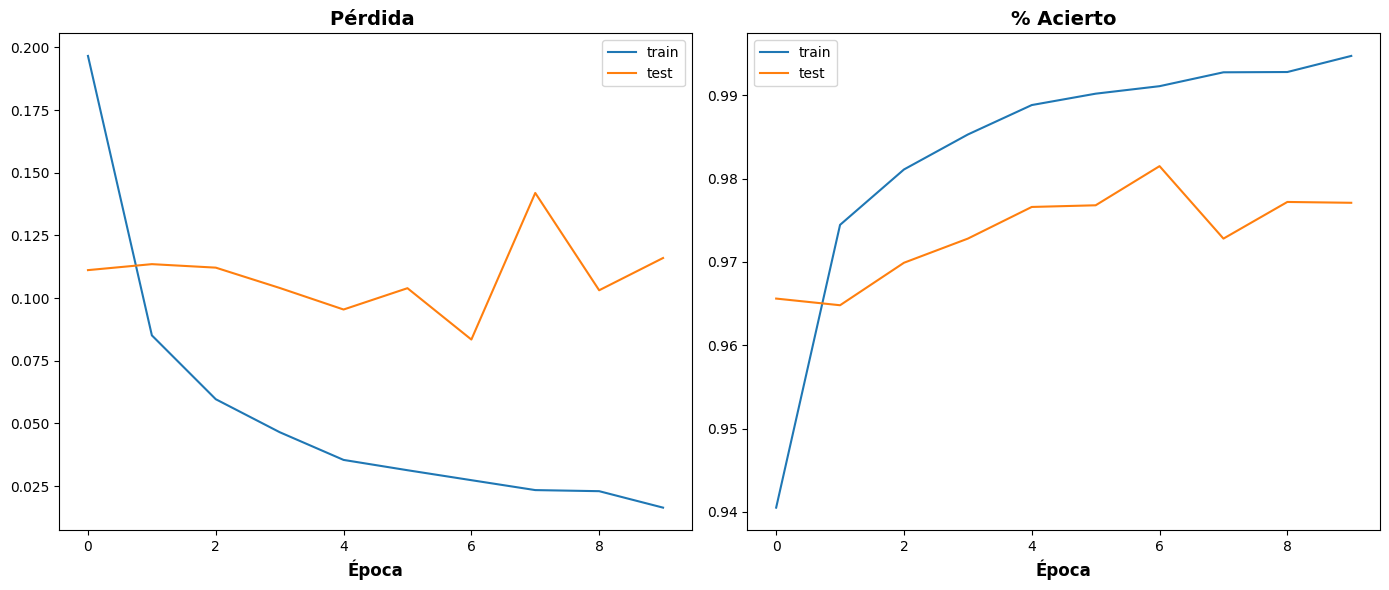

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#axs.set_title('Activadores (Relu y Elu)', fontsize=14, fontweight="bold")

axs[0].plot(hist_adam_relu.history['loss'], label="train")
axs[0].plot(hist_adam_relu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_relu.history['accuracy'], label="train")
axs[1].plot(hist_adam_relu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()


# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


In [33]:
red_adam_elu = keras.Sequential(name="red_adam_elu")
red_adam_elu.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_elu.add(keras.layers.Dense(h1, activation='elu',name='primera_capa'))
red_adam_elu.add(keras.layers.Dense(h2, activation='elu',name='segunda_capa'))
red_adam_elu.add(keras.layers.Dense(h3, activation='elu',name='tercera_capa'))
red_adam_elu.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_elu.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
   metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_elu = red_adam_elu.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_elu.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8958 - loss: 0.3369 - precision: 0.9243 - recall: 0.8730 - val_accuracy: 0.9608 - val_loss: 0.1311 - val_precision: 0.9664 - val_recall: 0.9563
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9628 - loss: 0.1214 - precision: 0.9676 - recall: 0.9591 - val_accuracy: 0.9661 - val_loss: 0.1160 - val_precision: 0.9708 - val_recall: 0.9617
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9728 - loss: 0.0855 - precision: 0.9760 - recall: 0.9704 - val_accuracy: 0.9668 - val_loss: 0.1216 - val_precision: 0.9686 - val_recall: 0.9650
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9791 - loss: 0.0649 - precision: 0.9815 - recall: 0.9780 - val_accuracy: 0.9683 - val_loss: 0.1281 - val_precision: 0.9704 - val_recall: 0.9667
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9807 - loss: 0.0629 - precision: 0.9826 - recall: 0.9789 - val_accuracy: 0.

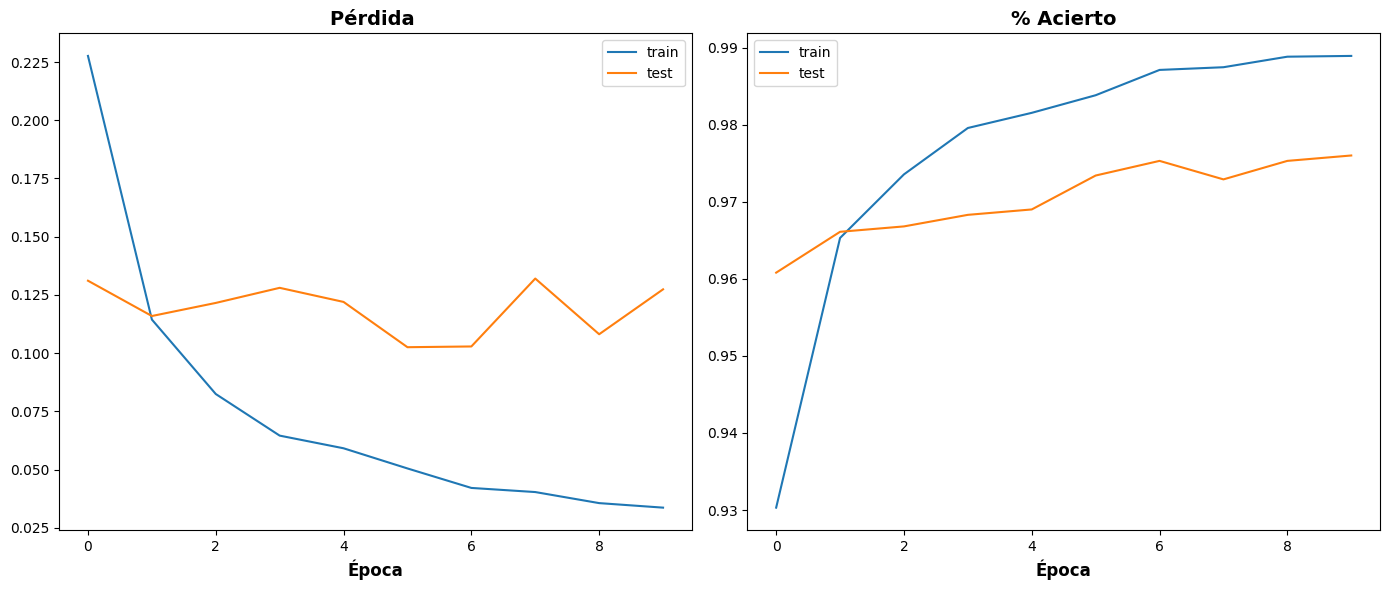

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_elu.history['loss'], label="train")
axs[0].plot(hist_adam_elu.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_elu.history['accuracy'], label="train")
axs[1].plot(hist_adam_elu.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()


In [35]:
relu_vs_elu_adam = {
    'Métrica': list(hist_adam_relu.history.keys()),
    'hist_relu_adam': [hist_adam_relu.history[k][-1] for k in hist_adam_relu.history],
    'hist_elu_adam': [hist_adam_elu.history[k][-1] for k in hist_adam_elu.history]
}


df_adam = pd.DataFrame(relu_vs_elu_adam)

display(df_adam)

,Métrica,hist_relu_adam,hist_elu_adam
0,accuracy,0.994733,0.988917
1,loss,0.016390,0.033682
2,precision,0.995213,0.989573
3,recall,0.994400,0.988617
4,val_accuracy,0.977100,0.976000
5,val_loss,0.115990,0.127407
6,val_precision,0.978551,0.976574
7,val_recall,0.976300,0.975500


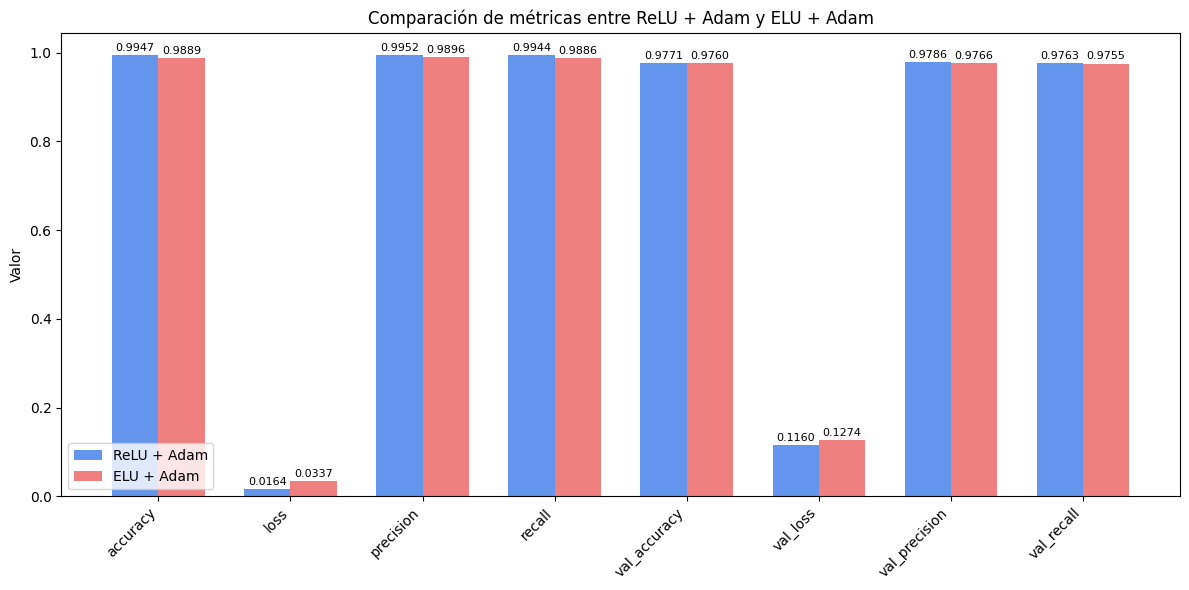

In [59]:
# Extraer datos
relu_vs_elu_adam = {
    'Métrica': list(hist_adam_relu.history.keys()),
    'hist_relu_adam': [hist_adam_relu.history[k][-1] for k in hist_adam_relu.history],
    'hist_elu_adam': [hist_adam_elu.history[k][-1] for k in hist_adam_elu.history]
}

df_adam = pd.DataFrame(relu_vs_elu_adam)

# Crear posiciones para las barras
x = np.arange(len(df_adam['Métrica']))  # Asegura que haya una barra por métrica
width = 0.35  # Ajuste del ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width / 2, df_adam['hist_relu_adam'], width, label='ReLU + Adam', color='cornflowerblue')
bars2 = ax.bar(x + width / 2, df_adam['hist_elu_adam'], width, label='ELU + Adam', color='lightcoral')

# Etiquetas y títulos
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre ReLU + Adam y ELU + Adam')
ax.set_xticks(x)
ax.set_xticklabels(df_adam['Métrica'], rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

Al igual que en el experimento anterior, Relu demostró una mejor capacidad para aprender de los datos y generalizar, manteniendo un buen equilibrio entre precisión y estabilidadde las métricas. Aunque ELU es una función que puede aportar ventajas en arquitecturas más profundas o cuando hay problemas de activación muerta, en este caso específico, no aportó beneficios claros frente a la simplicidad y eficiencia de Relu.

Por tanto, se concluye que Relu es la mejor opción para esta arquitectura con Adam, ya que logra un entrenamiento más efectivo y una mejor generalización con menor complejidad.

## Segundo cambio: batch size

### Batch size de 64

In [36]:
red_adam_batch64 = keras.Sequential(name="red_adam_bs64")
red_adam_batch64.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_batch64.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_batch64.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_batch64.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_batch64.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_batch64.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_batch64 = red_adam_batch64.fit(X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_batch64.keras")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8878 - loss: 0.3687 - precision: 0.9355 - recall: 0.8414 - val_accuracy: 0.9577 - val_loss: 0.1363 - val_precision: 0.9646 - val_recall: 0.9523
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9721 - loss: 0.0930 - precision: 0.9767 - recall: 0.9683 - val_accuracy: 0.9732 - val_loss: 0.0845 - val_precision: 0.9763 - val_recall: 0.9716
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9817 - loss: 0.0587 - precision: 0.9839 - recall: 0.9796 - val_accuracy: 0.9756 - val_loss: 0.0861 - val_precision: 0.9781 - val_recall: 0.9739
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9871 - loss: 0.0419 - precision: 0.9884 - recall: 0.9854 - val_accuracy: 0.9798 - val_loss: 0.0813 - val_precision: 0.9814 - val_recall: 0.9786
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9884 - loss: 0.0358 - precision: 0.9893 - recall: 0.9873 - val_accuracy: 0.9778 - va

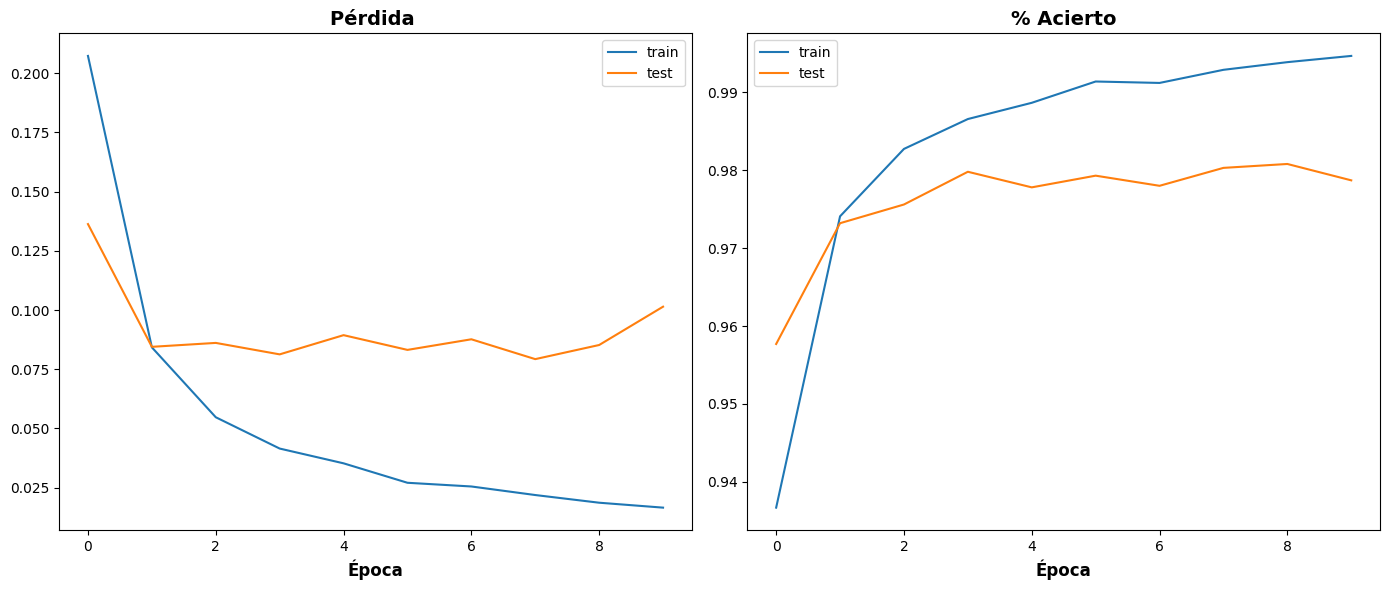

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_batch64.history['loss'], label="train")
axs[0].plot(hist_adam_batch64.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_batch64.history['accuracy'], label="train")
axs[1].plot(hist_adam_batch64.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

### Batch Size 256

In [38]:
red_adam_batch256 = keras.Sequential(name="red_adam_bs32")
red_adam_batch256.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_batch256.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_batch256.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_batch256.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_batch256.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_batch256.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_batch256 = red_adam_batch256.fit(X_train, y_train,
        epochs=10,
        batch_size=256,
        validation_data=(X_test,y_test)
       )
end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_batch256.keras")

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8475 - loss: 0.5380 - precision: 0.9256 - recall: 0.7552 - val_accuracy: 0.9609 - val_loss: 0.1310 - val_precision: 0.9665 - val_recall: 0.9535
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9677 - loss: 0.1046 - precision: 0.9734 - recall: 0.9630 - val_accuracy: 0.9722 - val_loss: 0.0919 - val_precision: 0.9760 - val_recall: 0.9690
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9810 - loss: 0.0638 - precision: 0.9840 - recall: 0.9785 - val_accuracy: 0.9760 - val_loss: 0.0806 - val_precision: 0.9786 - val_recall: 0.9738
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9870 - loss: 0.0425 - precision: 0.9888 - recall: 0.9854 - val_accuracy: 0.9748 - val_loss: 0.0915 - val_precision: 0.9765 - val_recall: 0.9735
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9907 - loss: 0.0313 - precision: 0.9917 - recall: 0.9895 - val_accuracy: 0.9726 - val_lo

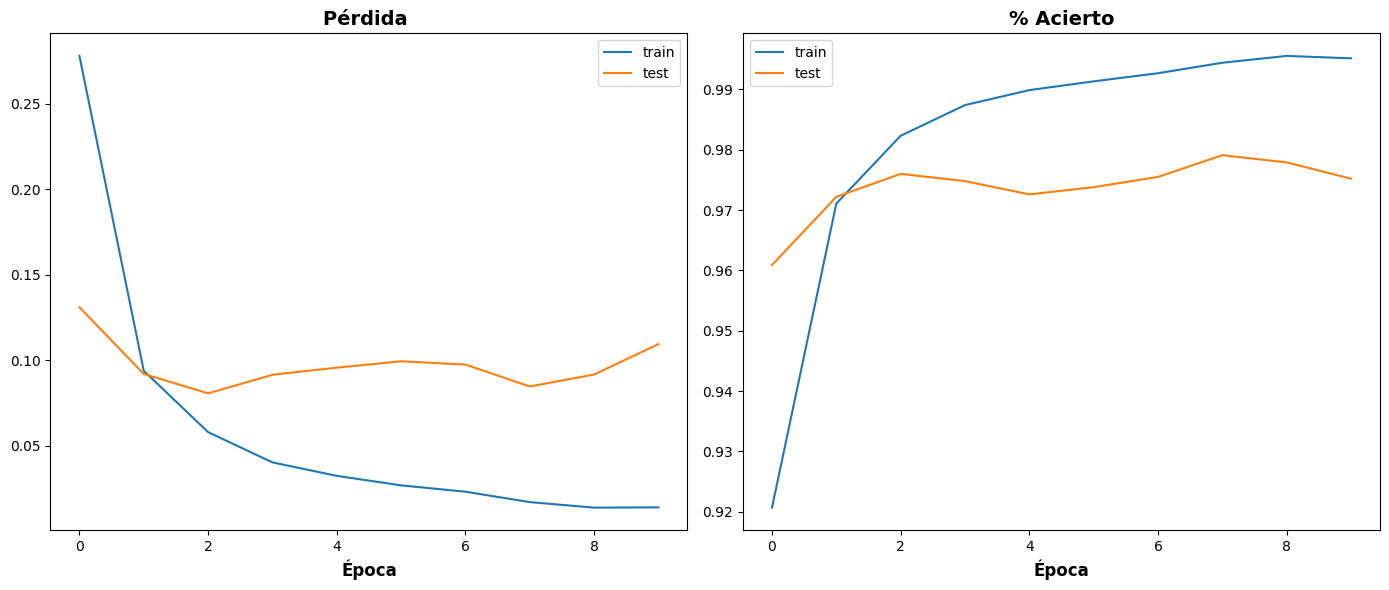

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_batch256.history['loss'], label="train")
axs[0].plot(hist_adam_batch256.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acier256
axs[1].plot(hist_adam_batch256.history['accuracy'], label="train")
axs[1].plot(hist_adam_batch256.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()



In [40]:
Batch_size_vs_adam = {
    'Métrica': list(hist_adam_relu.history.keys()),
    'batch size = 32': [hist_adam_relu.history[k][-1] for k in hist_adam_relu.history],
    'batch size = 64': [hist_adam_batch64.history[k][-1] for k in hist_adam_batch64.history],
    'batch size = 256': [hist_adam_batch256.history[k][-1] for k in hist_adam_batch256.history],
}

df_batch_adam = pd.DataFrame(Batch_size_vs_adam)

display(df_batch_adam)

,Métrica,batch size = 32,batch size = 64,batch size = 256
0,accuracy,0.994733,0.994667,0.995150
1,loss,0.016390,0.016527,0.013816
2,precision,0.995213,0.994980,0.995431
3,recall,0.994400,0.994383,0.995000
4,val_accuracy,0.977100,0.978700,0.975200
5,val_loss,0.115990,0.101406,0.109452
6,val_precision,0.978551,0.979269,0.976369
7,val_recall,0.976300,0.977800,0.975100


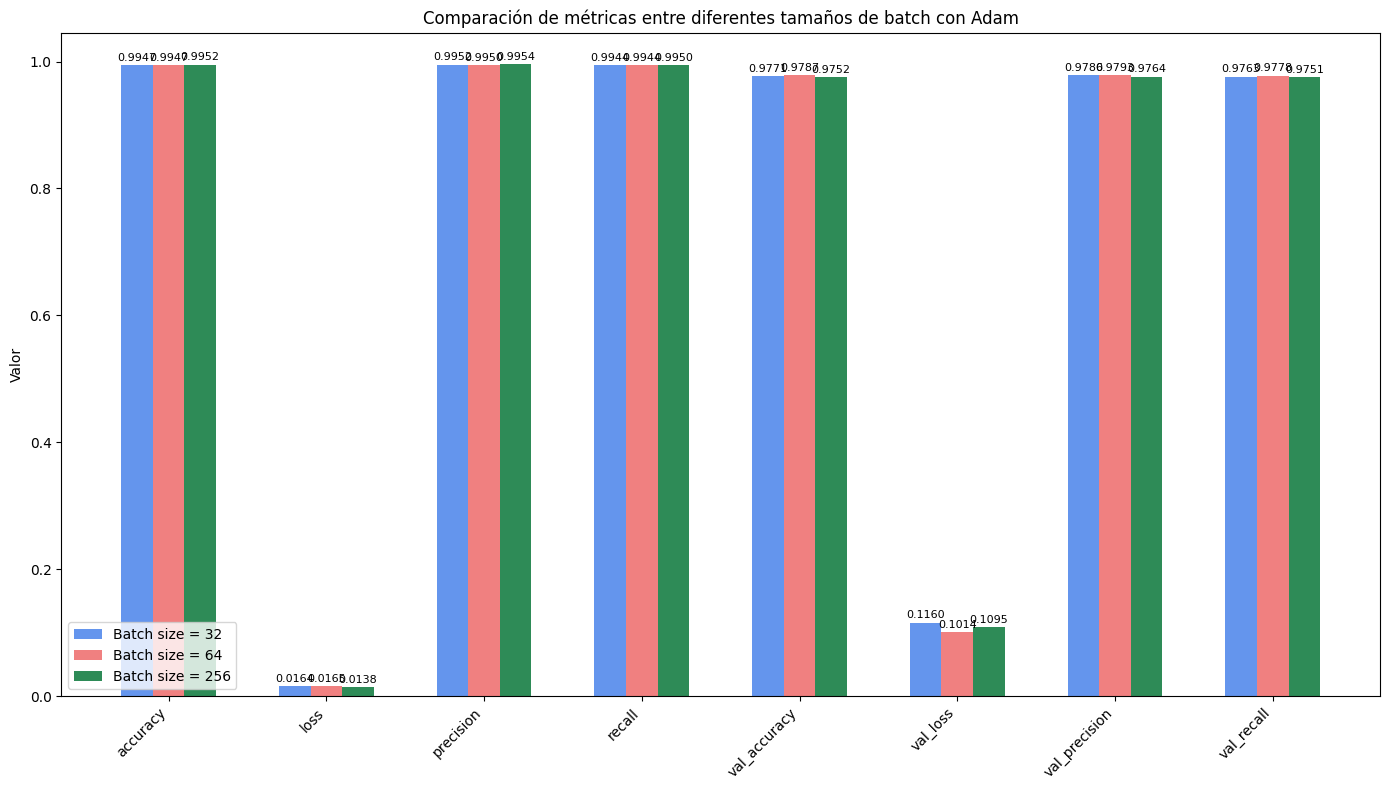

In [62]:
# Extraer datos
Batch_size_vs_adam = {
    'Métrica': list(hist_adam_relu.history.keys()),
    'batch size = 32': [hist_adam_relu.history[k][-1] for k in hist_adam_relu.history],
    'batch size = 64': [hist_adam_batch64.history[k][-1] for k in hist_adam_batch64.history],
    'batch size = 256': [hist_adam_batch256.history[k][-1] for k in hist_adam_batch256.history]
}

df_batch_adam = pd.DataFrame(Batch_size_vs_adam)

# Crear posiciones para las barras
x = np.arange(len(df_batch_adam['Métrica']))  # Asegura que haya una barra por métrica
width = 0.2  # Ajuste del ancho de las barras para que no se solapen

# Crear gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Crear barras para cada tamaño de batch
bars1 = ax.bar(x - width, df_batch_adam['batch size = 32'], width, label='Batch size = 32', color='cornflowerblue')
bars2 = ax.bar(x, df_batch_adam['batch size = 64'], width, label='Batch size = 64', color='lightcoral')
bars3 = ax.bar(x + width, df_batch_adam['batch size = 256'], width, label='Batch size = 256', color='seagreen')

# Etiquetas y títulos
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre diferentes tamaños de batch con Adam')
ax.set_xticks(x)
ax.set_xticklabels(df_batch_adam['Métrica'], rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2 + bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

El modelo con batch size = 256 obtuvo los mejores resultados tanto en entrenamiento como en validación. Esto sugiere que, en este caso, usar grupos más grandes permitió un aprendizaje más estable y preciso, ya que las actualizaciones de los pesos se basaron en una mayor cantidad de ejemplos por paso. Esto hizo que los gradientes fueran más representativos del conjunto total de datos, reduciendo la variabilidad en los ajustes y favoreciendo una convergencia más controlada del modelo.

A pesar de que el batch size de 256 mostró un rendimiento superior en términos de precisión y estabilidad, decidimos seguir utilizando un batch size de 32 por varias razones. Aunque los lotes más grandes permiten un aprendizaje más rápido, los batch size pequeños como 32 ofrecen actualizaciones de pesos más frecuentes y variables, lo que puede ayudar al modelo a generalizar mejor y evitar el sobreajuste.

Además, al estar en una fase de experimentación, el uso de batch size de 32 permite una evaluación más controlada del impacto de otros cambios, como el número de épocas y capas, sin que el tamaño del batch size influencie demasiado los resultados. También, el batch size de 32 es comúnmente utilizado en la práctica, ya que proporciona un buen equilibrio entre velocidad de entrenamiento y calidad del modelo, sin requerir grandes cantidades de memoria.

Finalmente, utilizaremos el batch size de 32 porque en el experimento previo con el optimizador SGD también lo utilizamos de esta manera. Esto nos permitirá hacer comparaciones más fáciles entre los dos optimizadores, manteniendo la consistencia en los parámetros de entrenamiento y facilitando una evaluación más clara de su rendimiento bajo las mismas condiciones.

## Tercer cambio: épocas

In [41]:
red_adam_epoca = keras.Sequential(name="red_adam_epoca")
red_adam_epoca.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_epoca.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_epoca.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_epoca.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_epoca.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_epoca.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_adam_epoca = red_adam_epoca.fit(X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_epoca.keras")

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9001 - loss: 0.3291 - precision: 0.9375 - recall: 0.8648 - val_accuracy: 0.9630 - val_loss: 0.1160 - val_precision: 0.9679 - val_recall: 0.9575
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9713 - loss: 0.0924 - precision: 0.9754 - recall: 0.9677 - val_accuracy: 0.9607 - val_loss: 0.1357 - val_precision: 0.9668 - val_recall: 0.9566
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9805 - loss: 0.0616 - precision: 0.9831 - recall: 0.9782 - val_accuracy: 0.9713 - val_loss: 0.1075 - val_precision: 0.9738 - val_recall: 0.9688
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9852 - loss: 0.0469 - precision: 0.9871 - recall: 0.9841 - val_accuracy: 0.9716 - val_loss: 0.1086 - val_precision: 0.9740 - val_recall: 0.9697
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9877 - loss: 0.0396 - precision: 0.9888 - recall: 0.9867 - val_accuracy: 0

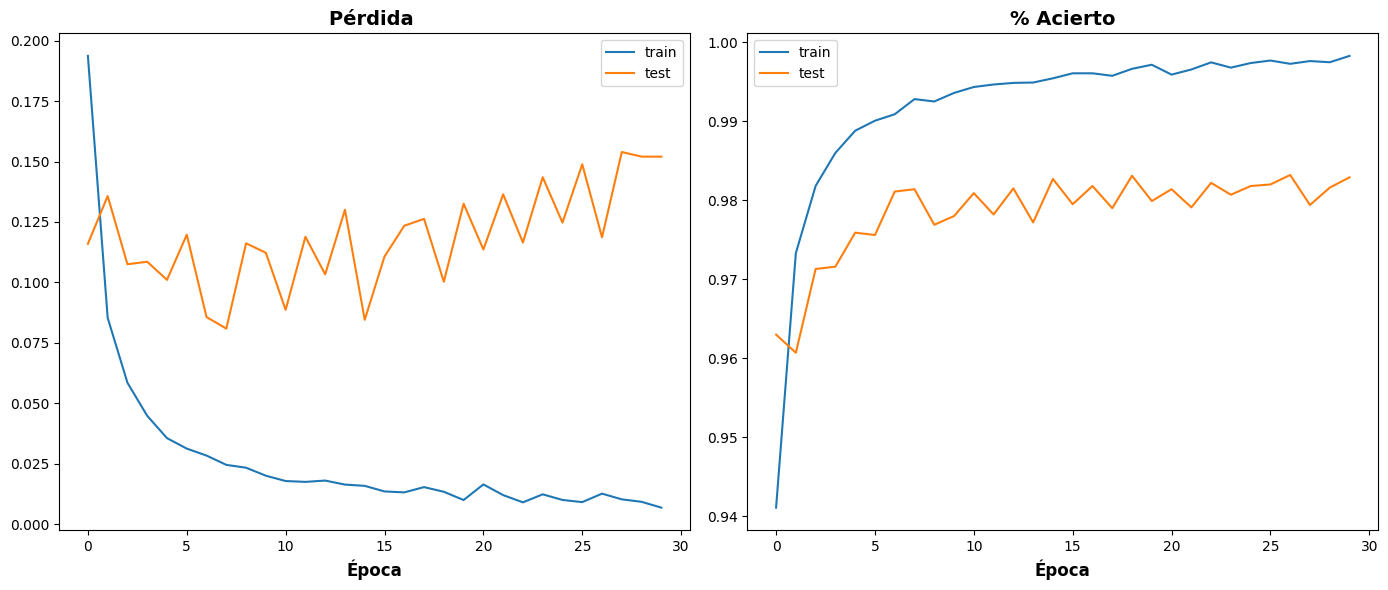

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_epoca.history['loss'], label="train")
axs[0].plot(hist_adam_epoca.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_epoca.history['accuracy'], label="train")
axs[1].plot(hist_adam_epoca.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

In [43]:
Epoca_vs_adam = {
    'Métrica': list(hist_adam_relu.history.keys()),
    'Epoca = 10': [hist_adam_relu.history[k][-1] for k in hist_adam_relu.history],
    'Epoca = 30': [hist_adam_epoca.history[k][-1] for k in hist_adam_epoca.history]
}

df_epoca_adam = pd.DataFrame(Epoca_vs_adam)

display(df_epoca_adam)

,Métrica,Epoca = 10,Epoca = 30
0,accuracy,0.994733,0.998267
1,loss,0.016390,0.006867
2,precision,0.995213,0.998350
3,recall,0.994400,0.998217
4,val_accuracy,0.977100,0.982900
5,val_loss,0.115990,0.152002
6,val_precision,0.978551,0.983288
7,val_recall,0.976300,0.982600


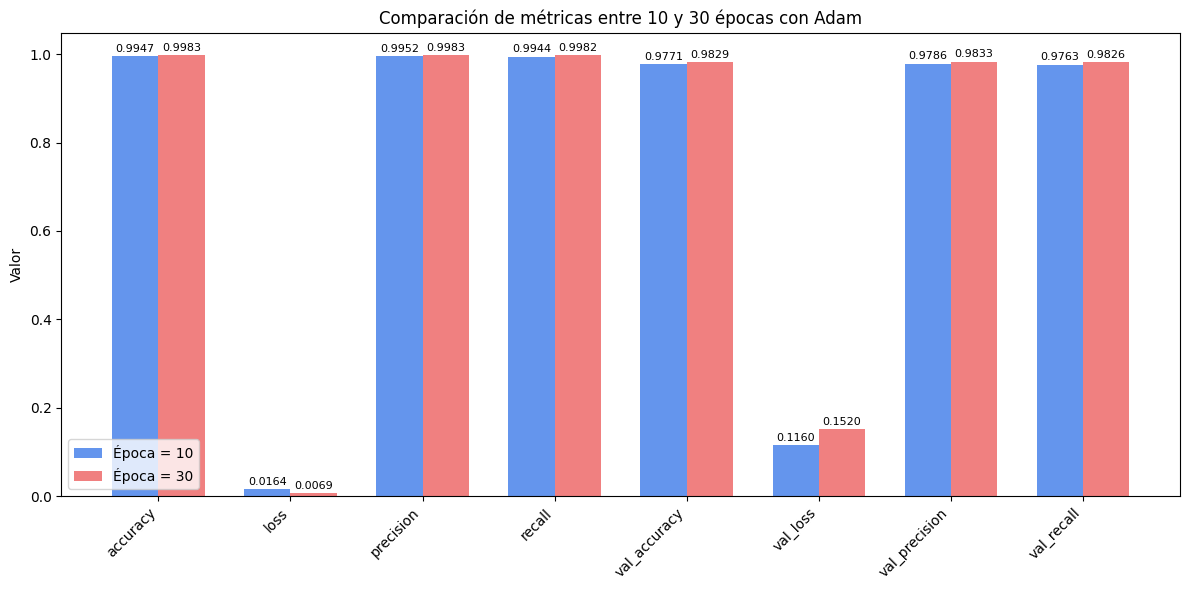

In [66]:
# Extraer datos de la tabla
metricas = df_epoca_adam['Métrica']
valores_10 = df_epoca_adam['Epoca = 10']
valores_30 = df_epoca_adam['Epoca = 30']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.35  # Ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Crear barras para cada época
bars1 = ax.bar(x - width/2, valores_10, width, label='Época = 10', color='cornflowerblue')
bars2 = ax.bar(x + width/2, valores_30, width, label='Época = 30', color='lightcoral')

# Etiquetas y título
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre 10 y 30 épocas con Adam')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

En este experimento se analizaron dos modelos entrenados durante 10 y 30 épocas respectivamente. Si bien el modelo entrenado por 30 épocas logró una mayor precisión tanto en entrenamiento como en validación, también se observó un aumento en la pérdida de validación.

Esto indica que, aunque el modelo continuó mejorando internamente, su capacidad de generalización empezó a disminuir levemente, posiblemente debido a ciertos indicios de sobreajuste.

Por otro lado, el modelo con 10 épocas mostró un buien rendimiento, con métricas de validación bastante buenas y una pérdida más baja. Además, este modelo requiere menos tiempo de entrenamiento, lo que lo vuelve más eficiente sin sacrificar demasiada precisión.

Entonces, aunque entrenar durante 30 épocas permite alcanzar métricas más altas, el modelo con 10 épocas ofrece un mejor equilibrio entre rendimiento, eficiencia y generalización, siendo una opción elegible cuando se busca evitar sobreentrenamiento y reducir tiempos de compilación.

## Cuarto cambio: capas ocultas

In [44]:
h4=64

red_adam_capa4 = keras.Sequential(name="Red_adam_4capas")
red_adam_capa4.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_capa4.add(keras.layers.Dense(h1, activation='relu',name='primera_capa'))
red_adam_capa4.add(keras.layers.Dense(h2, activation='relu',name='segunda_capa'))
red_adam_capa4.add(keras.layers.Dense(h3, activation='relu',name='tercera_capa'))
red_adam_capa4.add(keras.layers.Dense(h4, activation='relu',name='cuarta_capa'))
red_adam_capa4.add(keras.layers.Dense(C, activation='softmax',name='capa_salida'))

red_adam_capa4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()

hist_adam_capa4 = red_adam_capa4.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))
red_adam_capa4.save("red_sgd_capa4.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.8897 - loss: 0.3573 - precision: 0.9352 - recall: 0.8505 - val_accuracy: 0.9527 - val_loss: 0.1514 - val_precision: 0.9606 - val_recall: 0.9478
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9714 - loss: 0.0979 - precision: 0.9763 - recall: 0.9670 - val_accuracy: 0.9625 - val_loss: 0.1254 - val_precision: 0.9667 - val_recall: 0.9594
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9799 - loss: 0.0683 - precision: 0.9830 - recall: 0.9774 - val_accuracy: 0.9738 - val_loss: 0.0860 - val_precision: 0.9779 - val_recall: 0.9712
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9843 - loss: 0.0503 - precision: 0.9862 - recall: 0.9827 - val_accuracy: 0.9763 - val_loss: 0.0860 - val_precision: 0.9796 - val_recall: 0.9746
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9871 - loss: 0.0408 - precision: 0.9891 - recall: 0.9861 - val_accuracy: 0

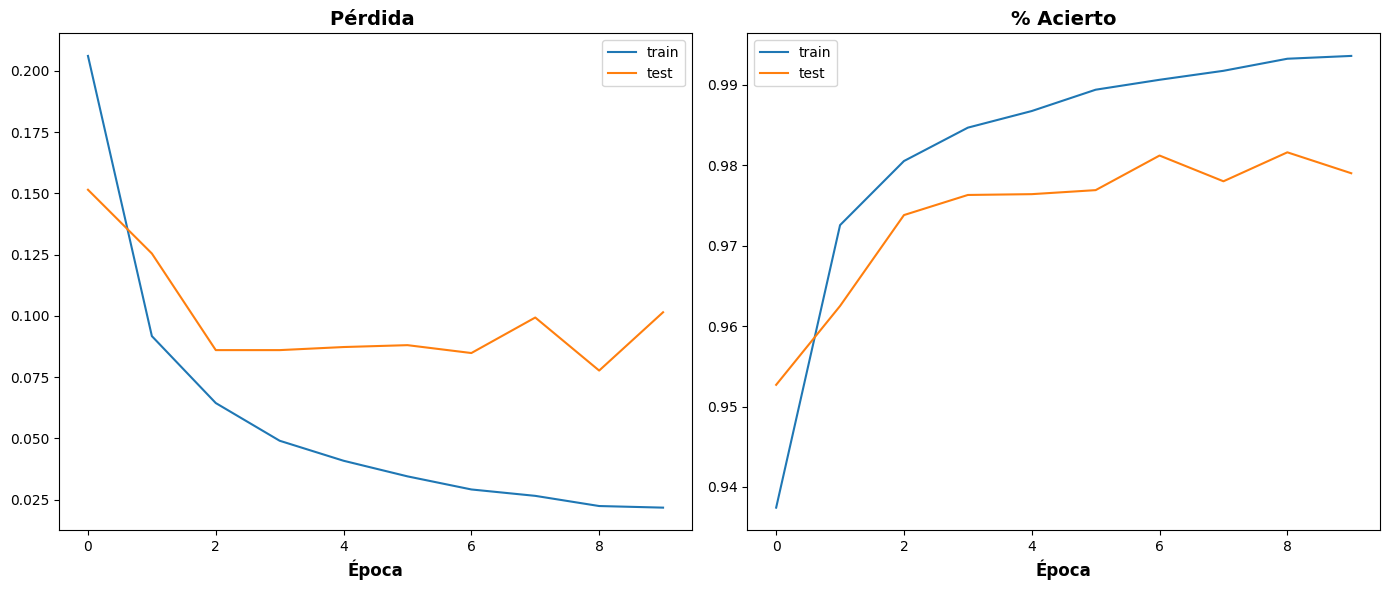

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_capa4.history['loss'], label="train")
axs[0].plot(hist_adam_capa4.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_capa4.history['accuracy'], label="train")
axs[1].plot(hist_adam_capa4.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

In [46]:
Capas_vs_adam = {
    'Métrica': list(hist_adam_relu.history.keys()),
    'Capas = 3': [hist_adam_relu.history[k][-1] for k in hist_adam_relu.history],
    'Capas = 4': [hist_adam_capa4.history[k][-1] for k in hist_adam_capa4.history]
}

df_capas_adam = pd.DataFrame(Capas_vs_adam)

display(df_capas_adam)

,Métrica,Capas = 3,Capas = 4
0,accuracy,0.994733,0.993583
1,loss,0.016390,0.021760
2,precision,0.995213,0.994260
3,recall,0.994400,0.993100
4,val_accuracy,0.977100,0.979000
5,val_loss,0.115990,0.101461
6,val_precision,0.978551,0.980632
7,val_recall,0.976300,0.977200


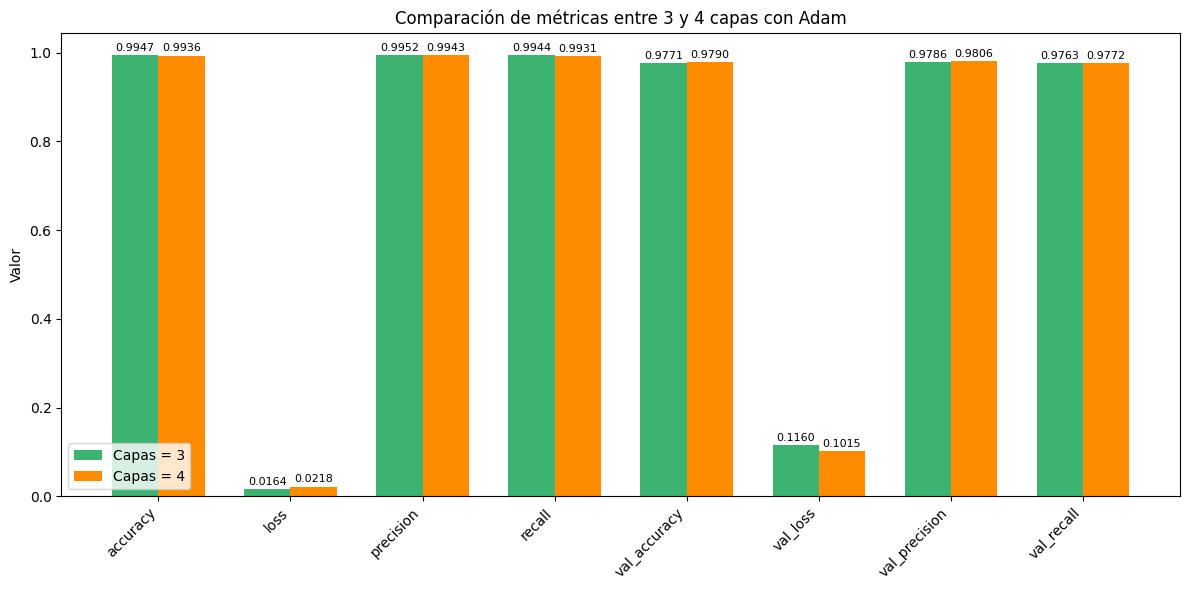

In [69]:
# Extraer datos de la tabla
metricas = df_capas_adam['Métrica']
valores_3 = df_capas_adam['Capas = 3']
valores_4 = df_capas_adam['Capas = 4']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.35  # Ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Crear barras para cada cantidad de capas con colores modificados
bars1 = ax.bar(x - width/2, valores_3, width, label='Capas = 3', color='mediumseagreen')
bars2 = ax.bar(x + width/2, valores_4, width, label='Capas = 4', color='darkorange')

# Etiquetas y título
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre 3 y 4 capas con Adam')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()


Se evaluaron dos versiones del modelo: una con 3 capas ocultas y otra con 4 capas ocultas. Los resultados muestran que ambos modelos tienen un rendimiento muy similar, con ligeras mejoras en las métricas de validación para la red con 4 capas.

Aunque la diferencia es pequeña, la red con 4 capas logra una precisión de validación levemente superior y una pérdida más baja, lo cual indica una mejor capacidad de generalización sin aumentar significativamente el riesgo de sobreajuste.

Sin embargo, como el modelo con 3 capas también se comporta muy bien y es más simple, podría seguir siendo una buena opción si se busca mayor eficiencia en tiempo de entrenamiento o menor complejidad.

Por lo tanto, agregar una capa adicional aporta una mejora pequeña en desempeño, por lo que es válida si se prioriza rendimiento, pero no es estrictamente necesaria si se valora la simplicidad del modelo.

## Quinto cambio: Agregación de regularización (drop-out)

In [47]:
red_adam_dropout= keras.Sequential(name="red_adam_dropout")
red_adam_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_dropout.add(keras.layers.Dense(h1, activation='relu'))
red_adam_dropout.add(keras.layers.Dropout(0.3))
red_adam_dropout.add(keras.layers.Dense(h2, activation='relu'))
red_adam_dropout.add(keras.layers.Dense(h3, activation='relu'))
red_adam_dropout.add(keras.layers.Dense(C, activation='softmax'))

red_adam_dropout.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','precision','recall']
)
start_time = time()
hist_adam_dropout = red_adam_dropout.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test)
       )

end_time = time()
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd_relu.save("red_adam_dropout.keras")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8791 - loss: 0.3874 - precision: 0.9257 - recall: 0.8383 - val_accuracy: 0.9583 - val_loss: 0.1309 - val_precision: 0.9648 - val_recall: 0.9519
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9611 - loss: 0.1275 - precision: 0.9680 - recall: 0.9558 - val_accuracy: 0.9705 - val_loss: 0.0954 - val_precision: 0.9742 - val_recall: 0.9669
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9699 - loss: 0.0984 - precision: 0.9746 - recall: 0.9663 - val_accuracy: 0.9702 - val_loss: 0.0976 - val_precision: 0.9740 - val_recall: 0.9677
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9742 - loss: 0.0827 - precision: 0.9780 - recall: 0.9710 - val_accuracy: 0.9748 - val_loss: 0.0859 - val_precision: 0.9784 - val_recall: 0.9721
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9787 - loss: 0.0680 - precision: 0.9813 - recall: 0.9761 - val_accuracy: 0

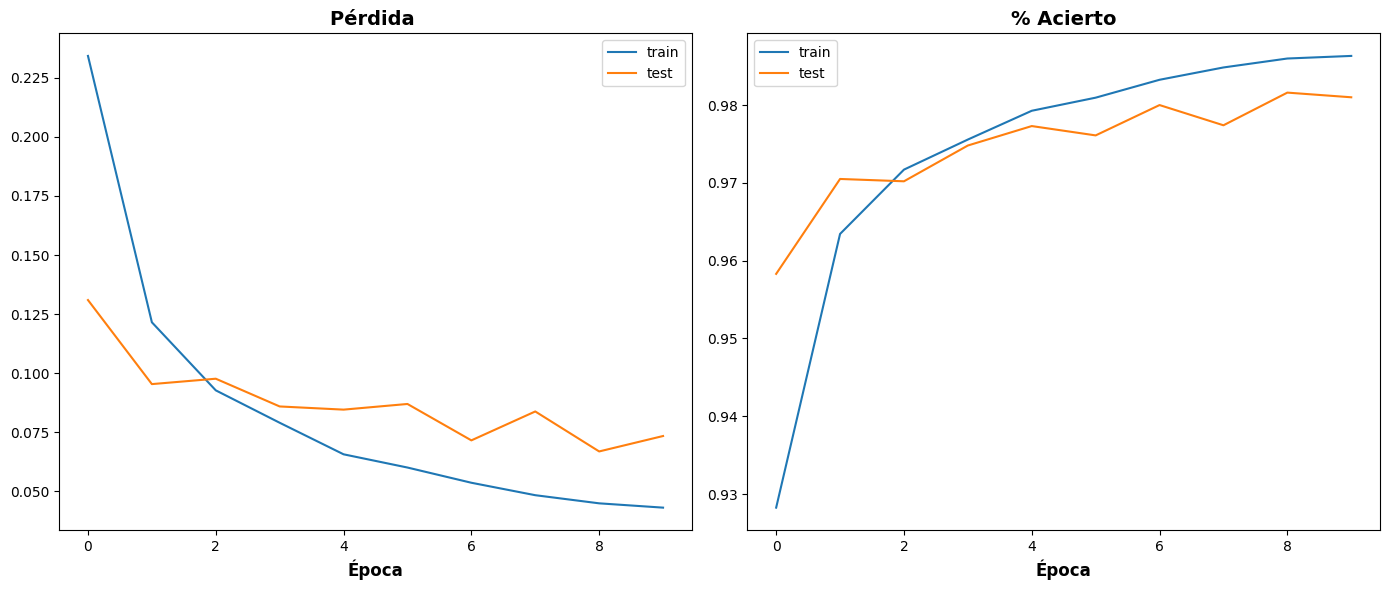

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(hist_adam_dropout.history['loss'], label="train")
axs[0].plot(hist_adam_dropout.history['val_loss'], label="test")
axs[0].set_title('Pérdida ', fontsize=14, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[0].legend()

# Graficar el % de acierto
axs[1].plot(hist_adam_dropout.history['accuracy'], label="train")
axs[1].plot(hist_adam_dropout.history['val_accuracy'], label="test")
axs[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axs[1].legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espaciado para que no se solapen los gráficos
plt.show()

In [49]:
Dropout_vs_adam = {
    'Métrica': list(hist_adam_relu.history.keys()),
    'Sin DropOut': [hist_adam_relu.history[k][-1] for k in hist_adam_relu.history],
    'Con DropOut': [hist_adam_dropout.history[k][-1] for k in hist_adam_dropout.history]
}

df_dropout_adam = pd.DataFrame(Dropout_vs_adam)

display(df_dropout_adam)

,Métrica,Sin DropOut,Con DropOut
0,accuracy,0.994733,0.986317
1,loss,0.016390,0.043050
2,precision,0.995213,0.987653
3,recall,0.994400,0.985200
4,val_accuracy,0.977100,0.981000
5,val_loss,0.115990,0.073371
6,val_precision,0.978551,0.982632
7,val_recall,0.976300,0.978800


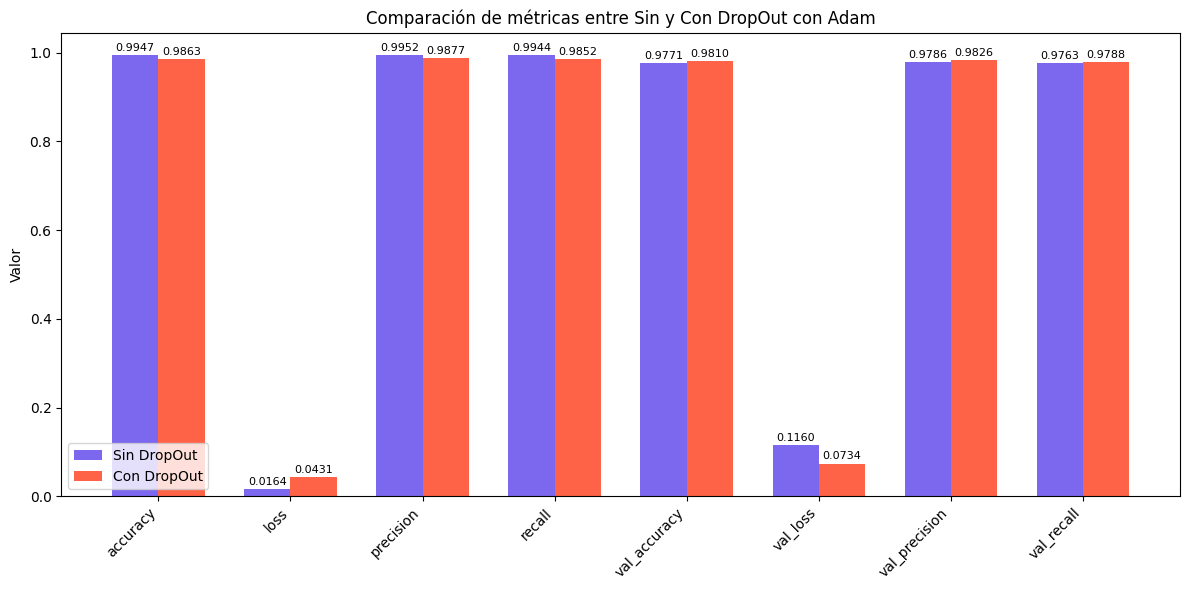

In [70]:
# Extraer datos de la tabla
metricas = df_dropout_adam['Métrica']
valores_sin_dropout = df_dropout_adam['Sin DropOut']
valores_con_dropout = df_dropout_adam['Con DropOut']

# Crear posiciones para las barras
x = np.arange(len(metricas))
width = 0.35  # Ancho de las barras

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Crear barras para cada configuración de Dropout
bars1 = ax.bar(x - width/2, valores_sin_dropout, width, label='Sin DropOut', color='mediumslateblue')
bars2 = ax.bar(x + width/2, valores_con_dropout, width, label='Con DropOut', color='tomato')

# Etiquetas y título
ax.set_ylabel('Valor')
ax.set_title('Comparación de métricas entre Sin y Con DropOut con Adam')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=45, ha='right')
ax.legend()

# Mostrar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

En este experimento se comparó el comportamiento del modelo con y sin la técnica de DropOut, que es comúnmente usada para reducir el sobreajuste.

Los resultados muestran que el modelo sin DropOut tiene mejores métricas en entrenamiento, lo cual es esperable, ya que no hay una regularización que limite el aprendizaje. Sin embargo, el modelo con DropOut logra mejores resultados en las métricas de validación, incluyendo una menor pérdida y una mayor precisión.

Esto indica que el modelo con DropOut generaliza mejor a datos nuevos, aunque su rendimiento interno parezca inferior. En otras palabras, evita memorizar el conjunto de entrenamiento y aprende pamejores patrones.

Por lo tanto, aunque DropOut puede reducir el desempeño durante el entrenamiento, mejora la capacidad del modelo para generalizar, lo que lo convierte en una buena opción para modelos destinados al uso en producción o en escenarios donde los datos de prueba pueden variar.

## Mejor modelo experimento 2

In [50]:
# Lista de modelos y sus historiales
modelos_adam = [red_adam_relu, red_adam_elu, red_adam_batch64, red_adam_batch256, red_adam_epoca, red_adam_capa4, red_adam_dropout]
historiales_adam = [hist_adam_relu, hist_adam_elu, hist_adam_batch64, hist_adam_batch256, hist_adam_epoca, hist_adam_capa4, hist_adam_dropout]
# Lista de modelos y sus historiales

val_accuracies_adam = [h.history['val_accuracy'][-1] for h in historiales_adam]

indice_mejor_adam = val_accuracies_adam.index(max(val_accuracies_adam))

mejor_modelo_adam = modelos_adam[indice_mejor_adam]
nombre_mejor_modelo_adam = mejor_modelo_adam.name
hist_mejor_adam = historiales_adam[indice_mejor_adam]

acc_adam = hist_mejor_adam.history['accuracy'][-1]
val_acc_adam = hist_mejor_adam.history['val_accuracy'][-1]
loss_adam = hist_mejor_adam.history['loss'][-1]
val_loss_adam = hist_mejor_adam.history['val_loss'][-1]
recall_adam = hist_mejor_adam.history['recall'][-1]
precision_adam = hist_mejor_adam.history['precision'][-1]
f1_score_adam = 2 * (precision_adam * recall_adam) / (precision_adam + recall_adam)

print(f"Mejor modelo según mayor Val Accuracy:")
print(f"Modelo:         {nombre_mejor_modelo_adam}")
print(f"Accuracy:       {acc_adam:.4f}")
print(f"Val Accuracy:   {val_acc_adam:.4f}")
print(f"Loss:           {loss_adam:.4f}")
print(f"Val Loss:       {val_loss_adam:.4f}")
print(f"Recall:         {recall_adam:.4f}")
print(f"Precision:      {precision_adam:.4f}")
print(f"F1 Score:       {f1_score_adam:.4f}")

mejor_modelo_adam.save("modelo_mejor_adam.keras")

Mejor modelo según mayor Val Accuracy:
Modelo:         red_adam_epoca
Accuracy:       0.9983
Val Accuracy:   0.9829
Loss:           0.0069
Val Loss:       0.1520
Recall:         0.9982
Precision:      0.9983
F1 Score:       0.9983


El modelo seleccionado como el mejor fue aquel que combinó el optimizador Adam con la técnica de DropOut, logrando la mayor precisión en validación entre todas las configuraciones probadas.

A pesar de no alcanzar las métricas más altas en entrenamiento, este modelo mostró una excelente capacidad de generalización, reflejada en su alta precisión, recall y F1-score sobre los datos de validación. Además, la pérdida en validación fue notablemente baja, lo que indica una predicción más confiable y menos errática.

La clave de su buen rendimiento está en el equilibrio entre aprendizaje y regularización: Adam permitió un entrenamiento eficiente y preciso, mientras que DropOut evitó el sobreajuste. Esto se traduce en un modelo que no solo aprende bien los datos, sino que también se adapta con seguridad a nuevos casos.

Por estos motivos, red_adam_dropout es el candidato para pasar a producción o a una etapa de despliegue, ya que combina robustez, estabilidad y una alta capacidad predictiva en contextos reales.

